# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC209A Introduction to Data Science

## Final Project: Alzheimer's Diagnosis


**Harvard University**<br/>
**Fall 2023**<br/>
**Group Members**: Aida York, Sydney Levy, Niki Ekstrom, Soline Boussard, Michelle Hewson

---

# Table of contents
1. [Introduction](#introduction)
    1. [Problem Statement](#problemstatement)
    2. [Flowchart](#flowchart)
    3. [Library Installation](#libraries)
2. [Data Loading & Cleaning](#dataloading)
    1. [Load in Data](#dataloading)
    2. [Clean/Preprocess Data](#dataclean)
3. [Exploratory Data Analysis](#eda)
4. [Baseline Models](#baseline)
    1. [Baseline Model for MRI-level Data](#baseline_mri)
    2. [Baseline Model for Subject-level Data](#baseline_sub)
5. [Tuned Models](#models)
    1. [Subject-Level Models](#sub_models)
        1. [Tuned Logistic Regression](#sub_log)
        2. [Tuned Decision Tree](#sub_dt)
        3. [Tuned Random Forest](#sub_rf)
        4. [Tuned XGBoost](#sub_xg)
        5. [Tuned XGBoost with SMOTE](#sub_xg_smote)
        6. [Tuned Multi-Layer Perceptron Neural Network](#sub_nn)
    3. [MRI-Level Models](#mri_models)
        1. [Tuned Logistic Regression](#mri_log)
        2. [Tuned Decision Tree](#mri_dt)
        3. [Tuned Random Forest](#mri_rf)
        4. [Tuned XGBoost](#mri_xg)
        5. [Tuned XGBoost with SMOTE](#mri_xg_smote)
        6. [Tuned Multi-Layer Perceptron Neural Network](#mri_nn)
6. [Model Performance](#performance)
    1. [Subject-Level Model Performances](#sub_performance)
    2. [MRI-Level Model Performances](#mri_performance)
7. [Results](#results)
8. [Future Work/Scope of Improvement](#future)

# Introduction <a name="introduction"></a>

## Problem Statement <a name="problemstatement"></a>

This project aims to understand how different factors affect whether a person develops dementia. The goal of our model is to predict the presence of dementia based on training parameters such as gender, socioeconomic status, age, number of years of education, MMSE score, eTIV, nWBV, and ASF. These insights will hopefully help doctors, clinical researchers, and affected patients who want more information on the causes of dementia, and potentially predicting whether a person will develop dementia. 

## Flowchart of Project

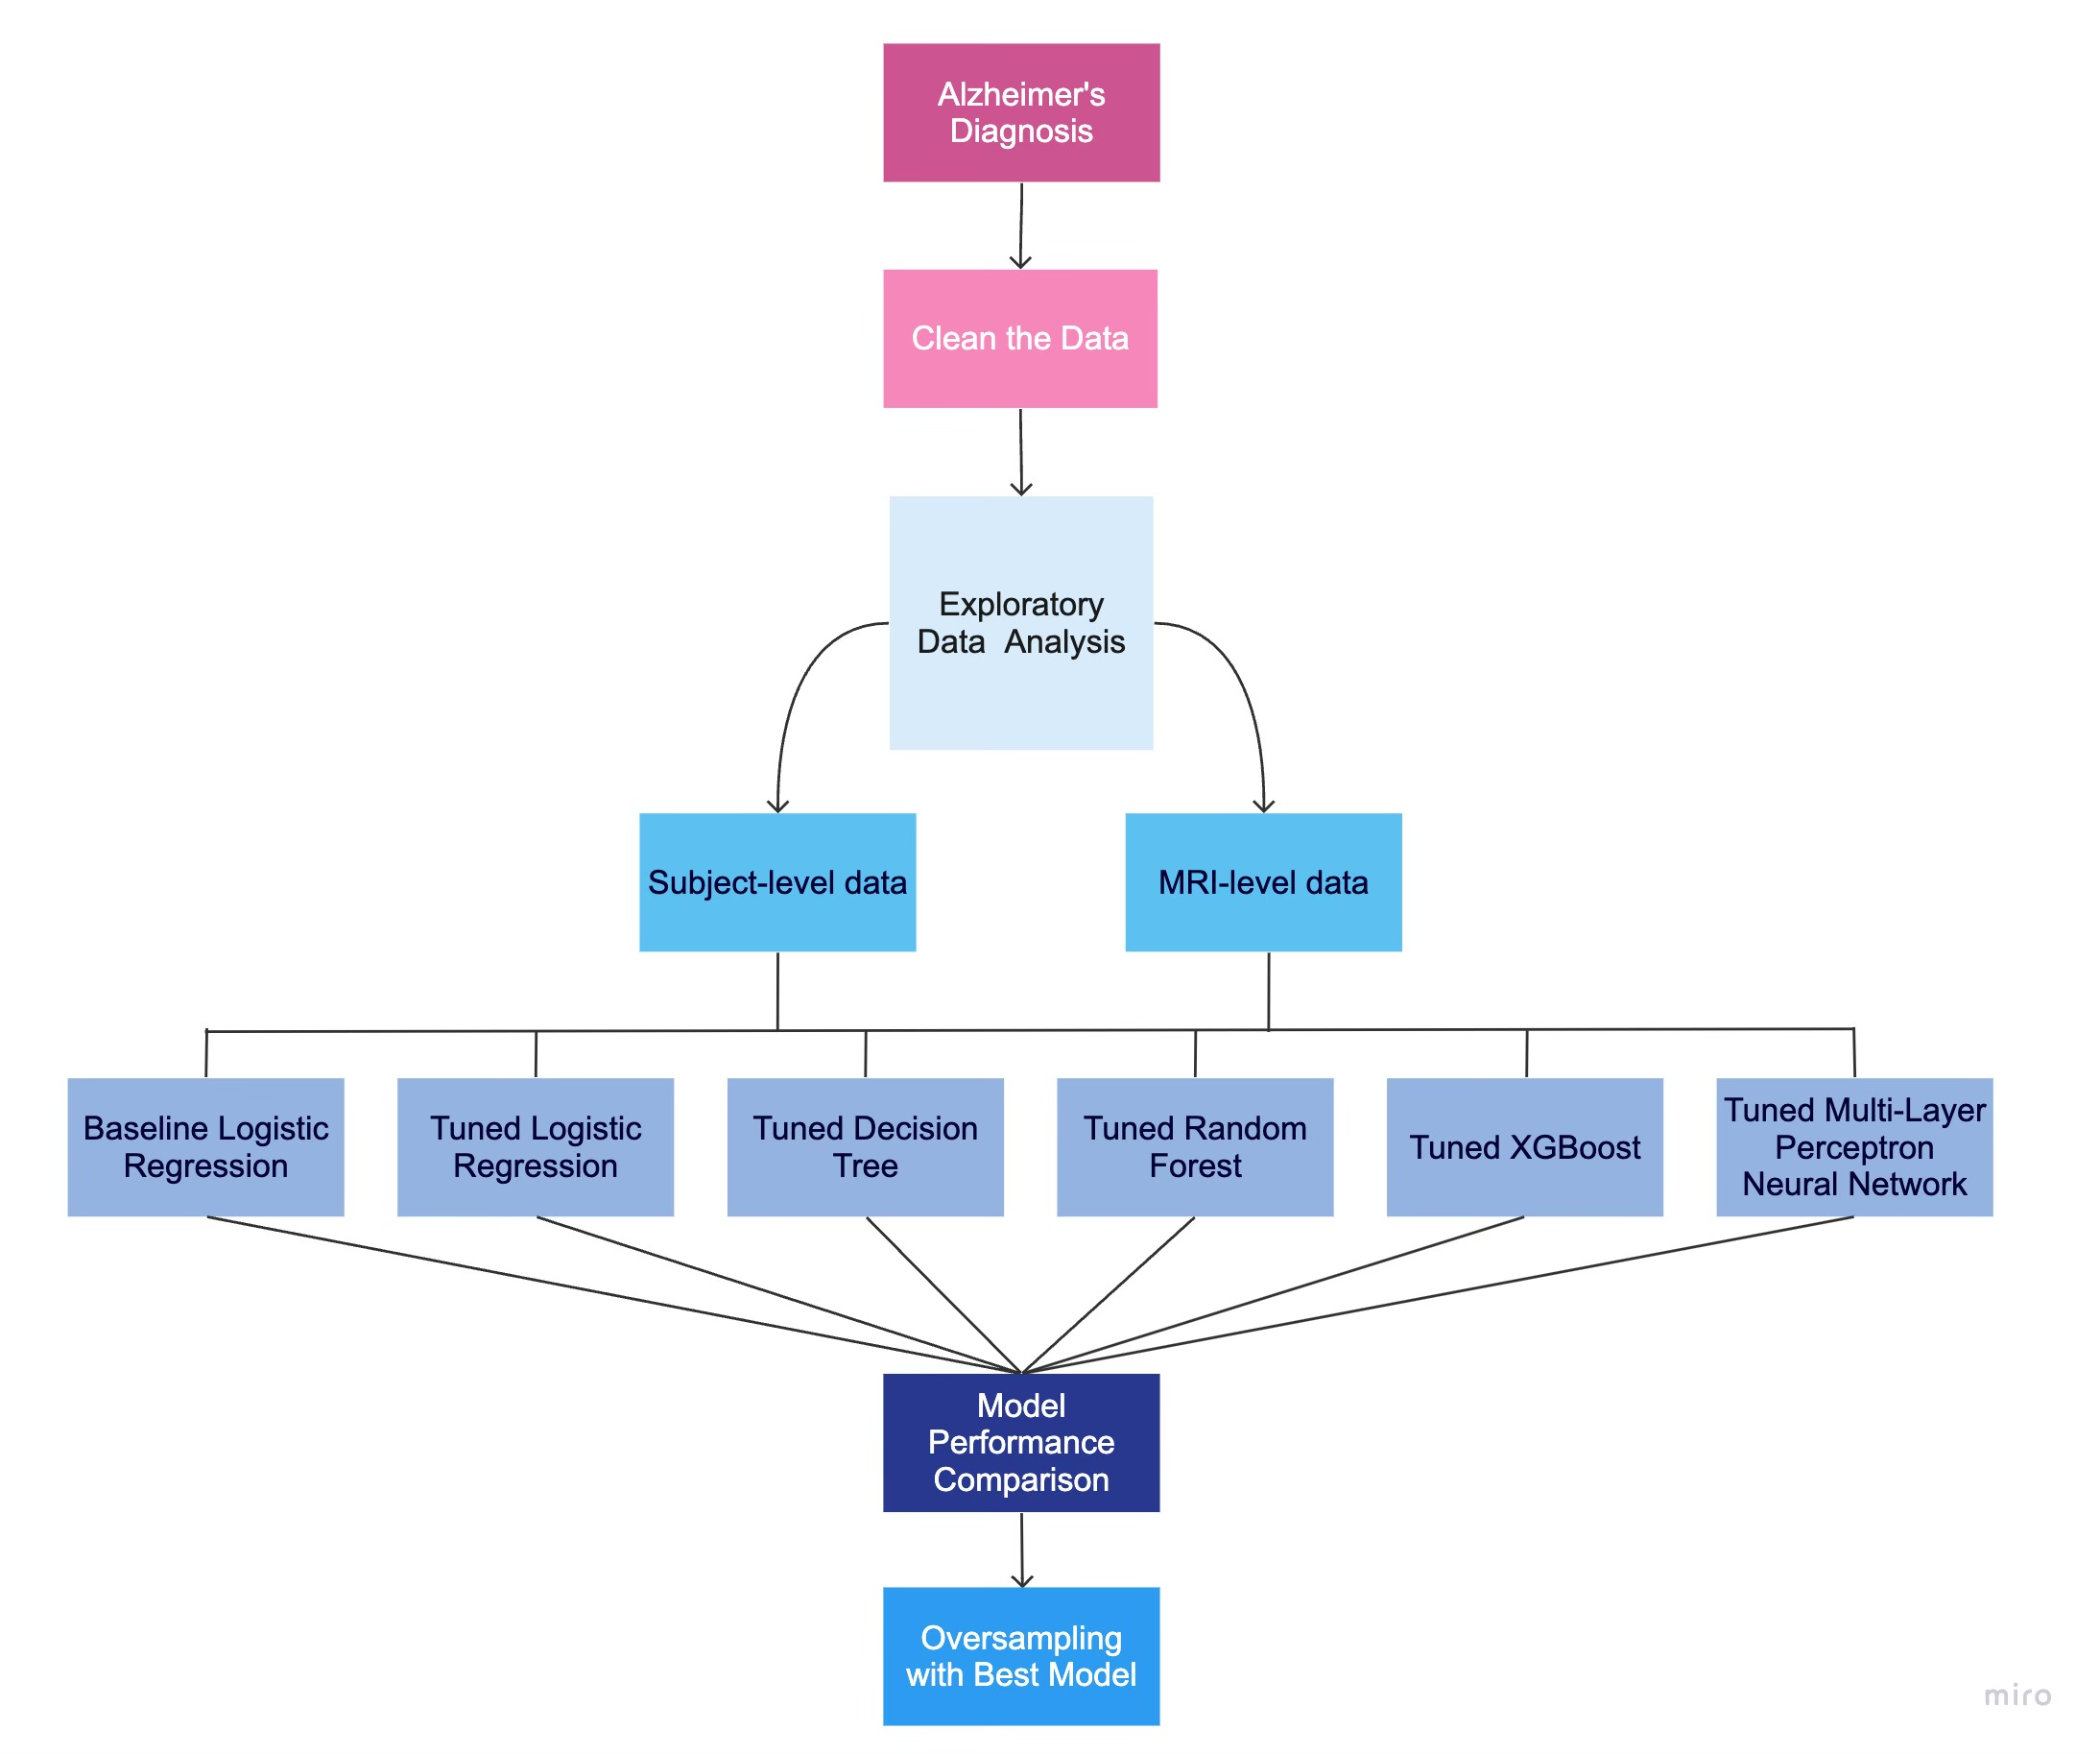

### Library Installation <a name="libraries"></a>

In [1]:
!pip3 install imblearn

In [2]:
!pip3 install plotly

In [3]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from warnings import simplefilter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from statsmodels.miscmodels.ordinal_model import OrderedModel 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

import plotly.graph_objects as go

### Library Dependencies

# Data Loading and Cleaning <a name="dataloading"></a>

### Variables in the dataset

- Subject ID: Unique identifier for each person
- MRI ID: Unique identifier for each MRI session
- Group: Categorical variable for nondemented, demented, and converted
- Visit: Visit number
- MR Delay: Days since first visit
- Hand: Whether subject is left or right handed
- Age: Age
- EDUC: Years of Education
- SES: Socioeconomic Status / 1-5
- MMSE: Mini Mental State Examination
- CDR: Clinical Dementia Rating
- eTIV: Estimated total intracranial volume
- nWBV: Normalize Whole Brain Volume
- ASF: Atlas Scaling Factor

In [4]:
# Load the datasets
df = pd.read_csv("data/oasis_longitudinal.csv", index_col = 0)

# Start by exploring the dataset and its descriptive statistics
df.head()

,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Subject ID,,,,,,,,,,,,,,
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [5]:
df.describe()
# Here, we notice that SES has 19 missing values, and MMSE has 3 missing values

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, OAS2_0001 to OAS2_0186
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MRI ID    373 non-null    object 
 1   Group     373 non-null    object 
 2   Visit     373 non-null    int64  
 3   MR Delay  373 non-null    int64  
 4   M/F       373 non-null    object 
 5   Hand      373 non-null    object 
 6   Age       373 non-null    int64  
 7   EDUC      373 non-null    int64  
 8   SES       354 non-null    float64
 9   MMSE      371 non-null    float64
 10  CDR       373 non-null    float64
 11  eTIV      373 non-null    int64  
 12  nWBV      373 non-null    float64
 13  ASF       373 non-null    float64
dtypes: float64(5), int64(5), object(4)
memory usage: 43.7+ KB


In [7]:
df.shape

(373, 14)

In [8]:
df[df['CDR']==2]
# Here we observe that only 3 patients in the study are classified with CDR = 2.0. This means that they have a severe case of dementia.

,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Subject ID,,,,,,,,,,,,,,
OAS2_0087,OAS2_0087_MR2,Demented,2,754,F,R,98,17,1.0,21.0,2.0,1503,0.66,1.168
OAS2_0120,OAS2_0120_MR2,Demented,2,595,F,R,78,14,3.0,15.0,2.0,1401,0.70,1.253
OAS2_0164,OAS2_0164_MR2,Demented,2,580,M,R,79,20,1.0,25.0,2.0,1710,0.76,1.026


## Cleaning the Data <a name="dataclean"></a>

We will start by preprocessing the data in order to facilitate visualization and correlations between different variables.


#### 1. Drop 'Hand'
Start by dropping the predictor 'Hand', since everyone is right-handed and this will not give us any insight when predicting dementia. 

In [9]:
df = df.drop('Hand', axis=1)
df

,MRI ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Subject ID,,,,,,,,,,,,,
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,82,16,1.0,28.0,0.5,1693,0.694,1.037
OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,86,16,1.0,26.0,0.5,1688,0.675,1.040
OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,61,13,2.0,30.0,0.0,1319,0.801,1.331


#### 2. Convert gender to binary variable
Start by changing male of female into a binary variable where male = 1 and female = 0.

In [10]:
df = df.rename(columns={'M/F': 'Male'})
df['Male'] = (df['Male'] == 'M').astype(int)
df

,MRI ID,Group,Visit,MR Delay,Male,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Subject ID,,,,,,,,,,,,,
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
OAS2_0002,OAS2_0002_MR1,Demented,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
OAS2_0002,OAS2_0002_MR2,Demented,2,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
OAS2_0185,OAS2_0185_MR2,Demented,2,842,1,82,16,1.0,28.0,0.5,1693,0.694,1.037
OAS2_0185,OAS2_0185_MR3,Demented,3,2297,1,86,16,1.0,26.0,0.5,1688,0.675,1.040
OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,0,61,13,2.0,30.0,0.0,1319,0.801,1.331


#### 3. One-hot encoding
Create one-hot encoding based on the "Group" variable. 

In [11]:
df_onehot = pd.get_dummies(df['Group'])
df_onehot.columns = ['converted', 'demented', 'non_demented']
df_onehot = df_onehot.astype(int)
df = pd.concat([df, df_onehot], axis=1)

df.head(10)

,MRI ID,Group,Visit,MR Delay,Male,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,converted,demented,non_demented
Subject ID,,,,,,,,,,,,,,,,
OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,0,1
OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876,0,0,1
OAS2_0002,OAS2_0002_MR1,Demented,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046,0,1,0
OAS2_0002,OAS2_0002_MR2,Demented,2,560,1,76,12,NaN,28.0,0.5,1738,0.713,1.010,0,1,0
OAS2_0002,OAS2_0002_MR3,Demented,3,1895,1,80,12,NaN,22.0,0.5,1698,0.701,1.034,0,1,0
OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444,0,0,1
OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,0,90,18,3.0,27.0,0.0,1200,0.718,1.462,0,0,1
OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039,0,0,1
OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,1,83,12,4.0,29.0,0.5,1701,0.711,1.032,0,0,1


#### 4. Grouping
Group the subjects by their demented class, which shows whether each person is demented, non_demented or converted.

As can be seen from the data, each subject had several visits and scans, meaning each subject corresponds to several rows in the dataframe.  

Therefore, we create a nested list that groups the data by Subject ID. This means that each entry in the nested list corresponds to one person, and that list contains the information about each visit and scan that person made.

This will make it easier to analyze the data later on because we will be able to extract information on a subject level.
For example, if we don't group by subject, a histogram of the ages of the subjects will not be accurate since some people's age will be listed several times.

In [12]:
nested_list = [group.values for name, group in df.groupby('Subject ID')]

print(nested_list[:3])

[array([['OAS2_0001_MR1', 'Nondemented', 1, 0, 1, 87, 14, 2.0, 27.0, 0.0,
        1987, 0.696, 0.883, 0, 0, 1],
       ['OAS2_0001_MR2', 'Nondemented', 2, 457, 1, 88, 14, 2.0, 30.0,
        0.0, 2004, 0.681, 0.876, 0, 0, 1]], dtype=object), array([['OAS2_0002_MR1', 'Demented', 1, 0, 1, 75, 12, nan, 23.0, 0.5,
        1678, 0.736, 1.046, 0, 1, 0],
       ['OAS2_0002_MR2', 'Demented', 2, 560, 1, 76, 12, nan, 28.0, 0.5,
        1738, 0.713, 1.01, 0, 1, 0],
       ['OAS2_0002_MR3', 'Demented', 3, 1895, 1, 80, 12, nan, 22.0, 0.5,
        1698, 0.701, 1.034, 0, 1, 0]], dtype=object), array([['OAS2_0004_MR1', 'Nondemented', 1, 0, 0, 88, 18, 3.0, 28.0, 0.0,
        1215, 0.71, 1.444, 0, 0, 1],
       ['OAS2_0004_MR2', 'Nondemented', 2, 538, 0, 90, 18, 3.0, 27.0,
        0.0, 1200, 0.718, 1.462, 0, 0, 1]], dtype=object)]


#### 5. Drop/Impute Missing Values

In [13]:
# First we investigate which columns have missing values
df.isna().sum()

MRI ID           0
Group            0
Visit            0
MR Delay         0
Male             0
Age              0
EDUC             0
SES             19
MMSE             2
CDR              0
eTIV             0
nWBV             0
ASF              0
converted        0
demented         0
non_demented     0
dtype: int64

In [14]:
# Drop rows with missing MMSE values as they account for less than 5% of the data
df = df.dropna(subset=['MMSE'])

In [15]:
# Use KNNImputer to impute missing values for SES because the missing values account for more than 5% of the data
imputer = KNNImputer(n_neighbors=4)
SES_imputed = imputer.fit_transform(df[['SES']])
df['SES'] = SES_imputed.astype(int)

In [16]:
# Confirm that we have dealt with all missing values cases
df.isna().sum()

MRI ID          0
Group           0
Visit           0
MR Delay        0
Male            0
Age             0
EDUC            0
SES             0
MMSE            0
CDR             0
eTIV            0
nWBV            0
ASF             0
converted       0
demented        0
non_demented    0
dtype: int64

# Exploratory Data Analysis <a name="eda"></a>

#### 1. Pairplot
- Separated the continuous variables in order to create a pairplot

By looking at the diagonal plots, we can see that there is a lot of overlap for the distirbutions of the different CDR values, meaning there could be a lot of characteristics that overlap between subjects with varying CDR values. In the remaining scatterplots, we don't see much separation between the different CDR values. 

/Users/levys/y/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


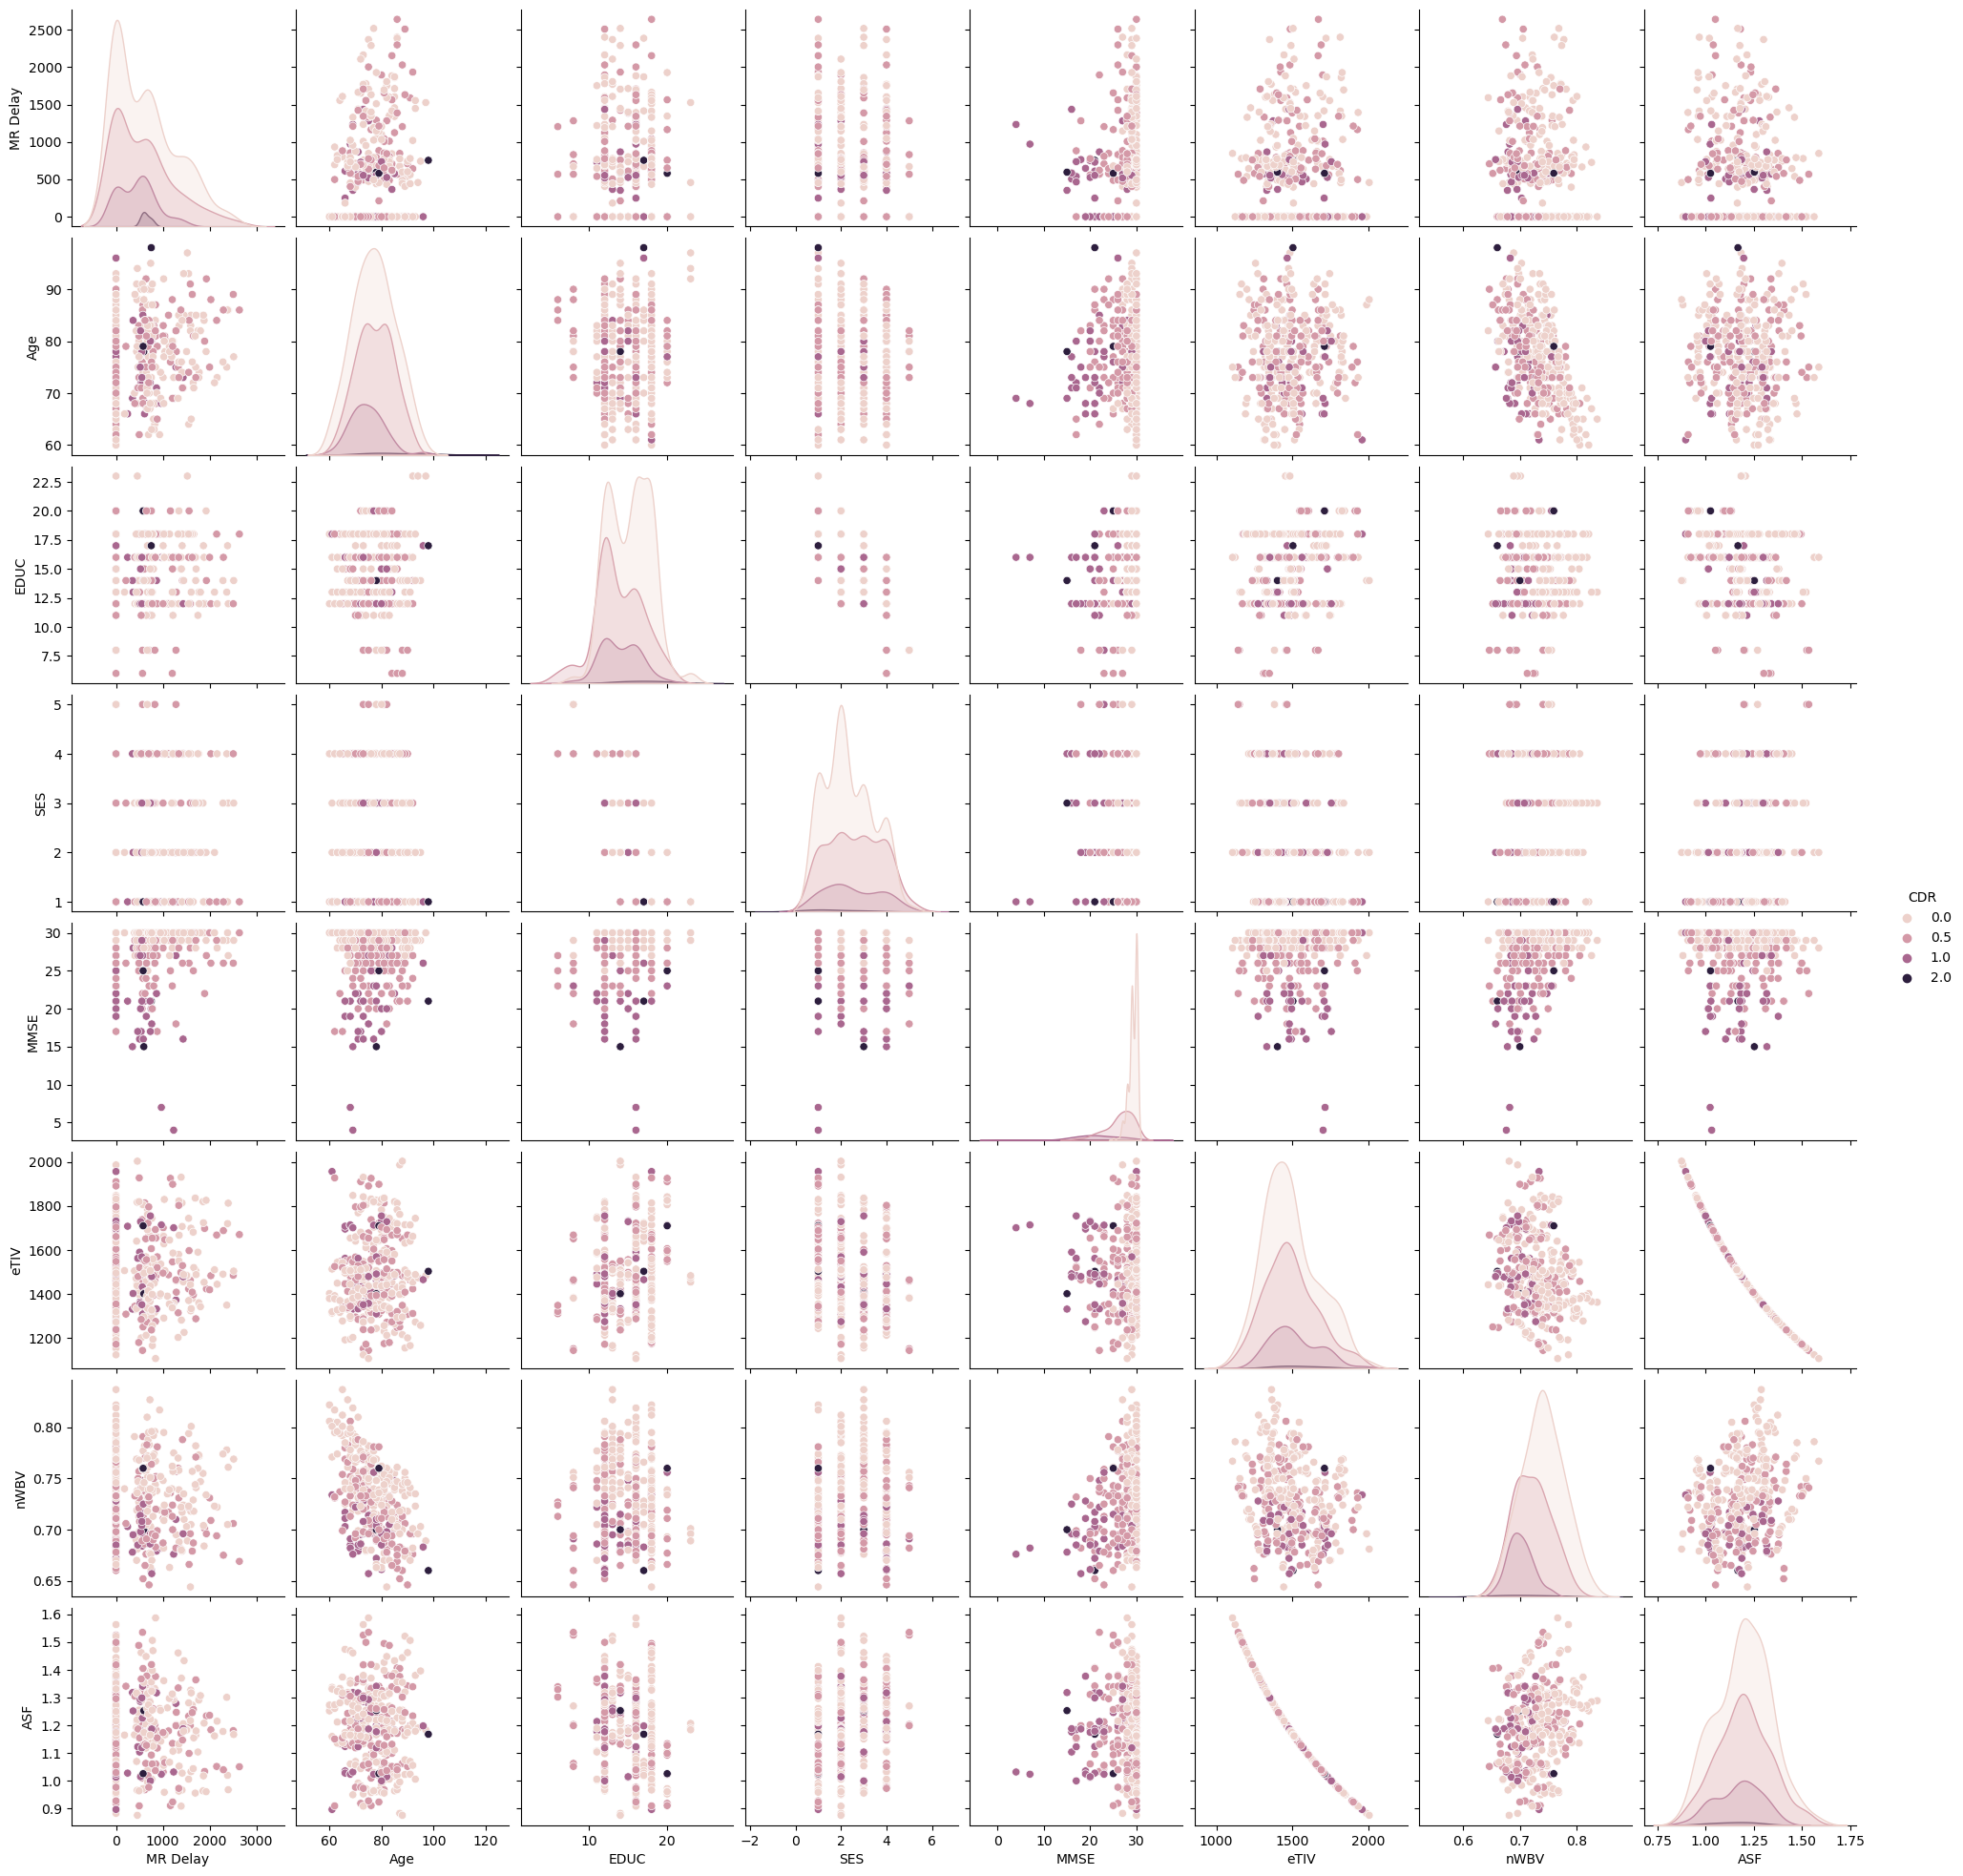

In [17]:
simplefilter('ignore', category=FutureWarning)
continuous = ['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV' ,'ASF', 'CDR']
df = df.reset_index()

sns.pairplot(df[continuous], hue='CDR');

#### 2. Correlation Matrix
- We plotted the absolute value of the correlation between the numeric variables
- We didn't include Subject ID or MRI ID since these are unique identifiers of each subject and should not be predictors of dementia.

Looking at the correlation matrix, we will not use Visit or MR Delay for predicting dementia, since they have a very low correlation with CDR. Additionally, these variables are not characteristics of the subject and therefore should not have an influence on whether a person develops dementia.

The variables with the strongest correlation to CDR are MMSE, nWBV, Male, and EDUC. Therefore, we will focus on these varibales for further exploration.

Depending on the style of visualization, we will use either "Group" or "CDR". These variables both correspond to a dementia rating, and roughly translate to the same idea. 

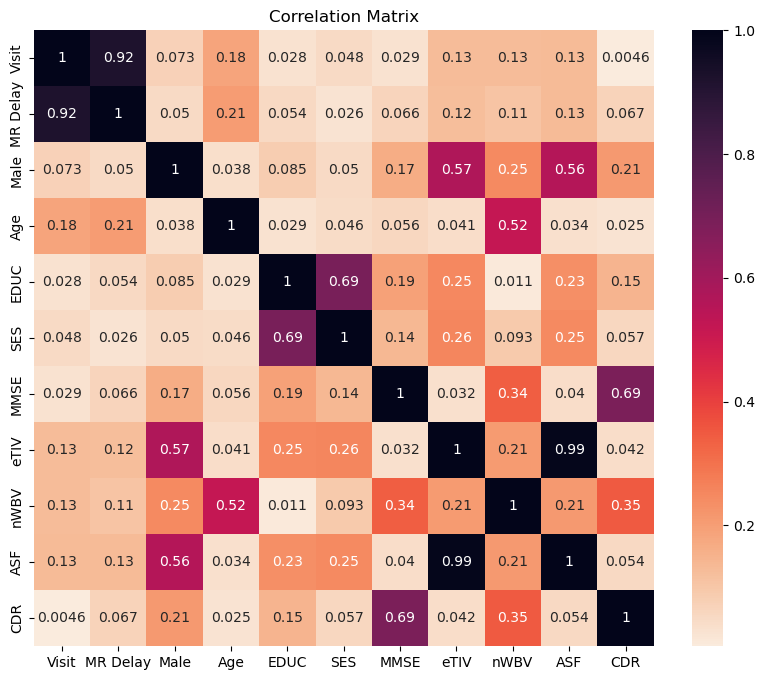

In [18]:
plt.figure(figsize= (10,8))
corr_cols = df[[ 'Visit', 'MR Delay', 'Male', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF','CDR']].copy()
sns.heatmap(np.abs(corr_cols.corr()), annot=True, cmap="rocket_r");
plt.title('Correlation Matrix');

#### 3. Boxplot of continuous variables vs. CDR

The box plots demonstrate the distribution of continuous variables across CDR. MMSE has the greatest difference in distribution across levels of CDR, where higher levels of MMSE are associated with a CDR of 0 and lower levels of MMSE are associated with CDR levels 1 and 2. There are a couple of potential outliers in the MMSE, MR delay, eTIV, Age, and SES. 

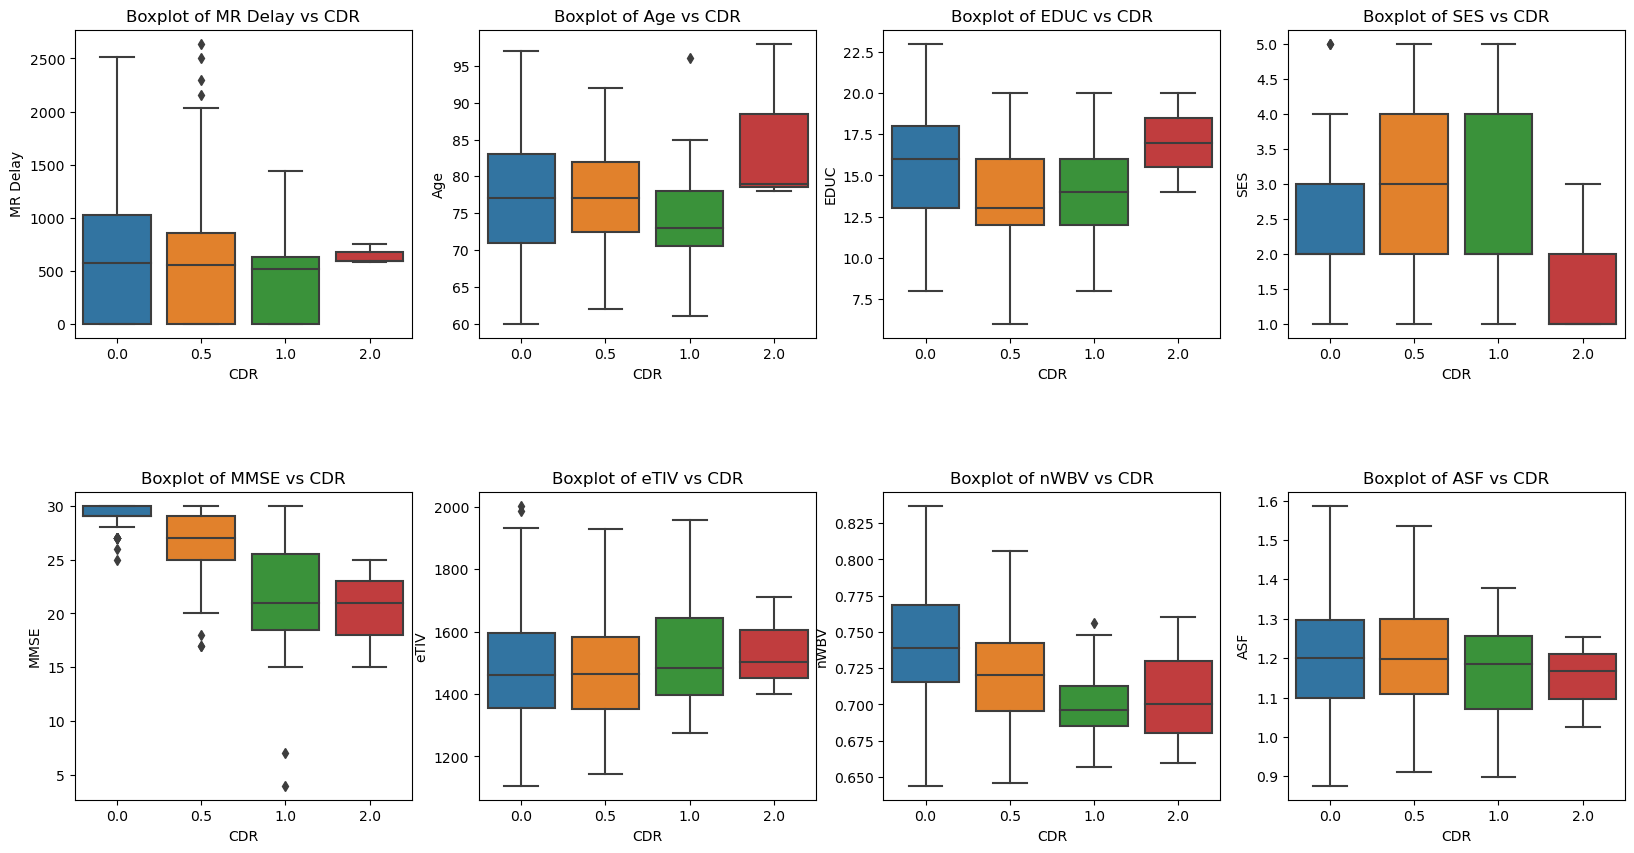

In [125]:
non_CDR_cont = ['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV' ,'ASF']

# Calculate the number of rows needed based on the number of continuous variables
num_rows = (len(non_CDR_cont) + 3) // 4  # Ceiling division for a 4-column grid

# Create subplots for each continuous variable in a 4-column grid
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Iterate through continuous variables and create boxplots
for i, var in enumerate(non_CDR_cont):
    row = i // 4
    col = i % 4
    sns.boxplot(x=df['CDR'], y=df[var], ax=axes[row, col])
    axes[row, col].set_title(f'Boxplot of {var} vs CDR')

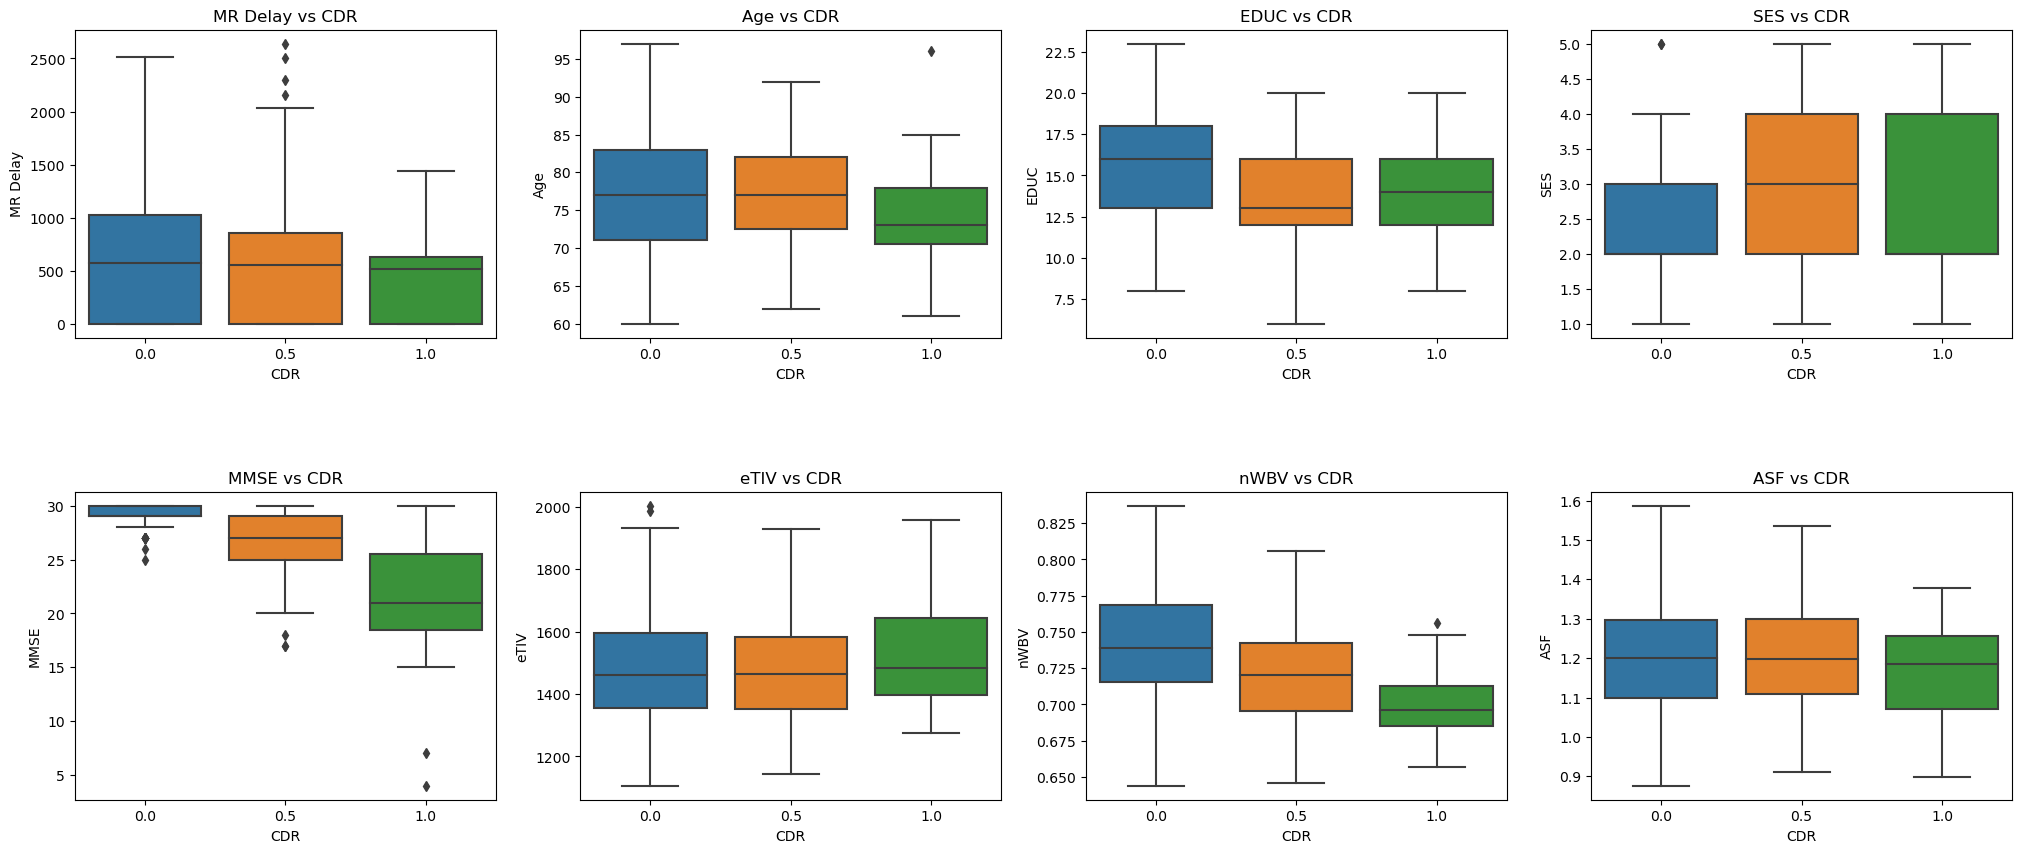

In [131]:
non_CDR_cont = ['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

filtered_df = df[df['CDR'].isin([0, 0.5, 1])]

num_rows = (len(non_CDR_cont) + 3) // 4  
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(25, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)

for i, var in enumerate(non_CDR_cont):
    row = i // 4
    col = i % 4
    sns.boxplot(x='CDR', y=var, data=filtered_df, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs CDR')

# Show the plot
plt.show()

#### 4. Relationship between gender and CDR

Findings:
- There are more females than males that have a CDR value of 0
- There are more males than females that have a CDR value of 0.5 
- There are slightly more males than females that have a CDR value of 1.0
- There are very few people with a CDR rating of 2.0
- Overall, there are more females than males in the dataset

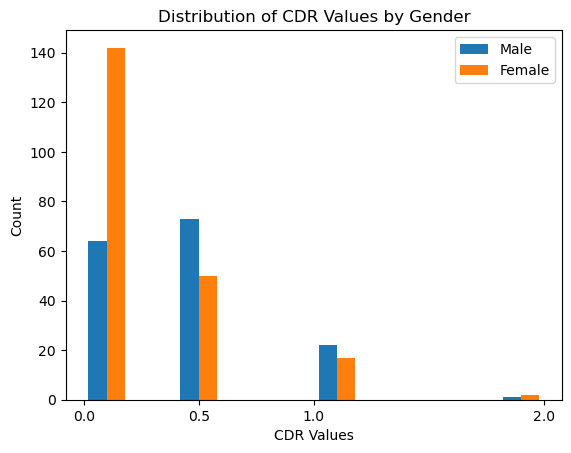

In [20]:
male = df[df['Male']==1]['CDR']
female = df[df['Male']==0]['CDR']

plt.hist([male.values, female.values], label=['Male', 'Female'])
plt.legend()
plt.xticks([0, 0.5, 1, 2]);
plt.xlabel('CDR Values')
plt.ylabel('Count')
plt.title('Distribution of CDR Values by Gender');

#### 5. Relationship between MMSE score and CDR

We can see a negative correlation between MMSE score and CDR. 

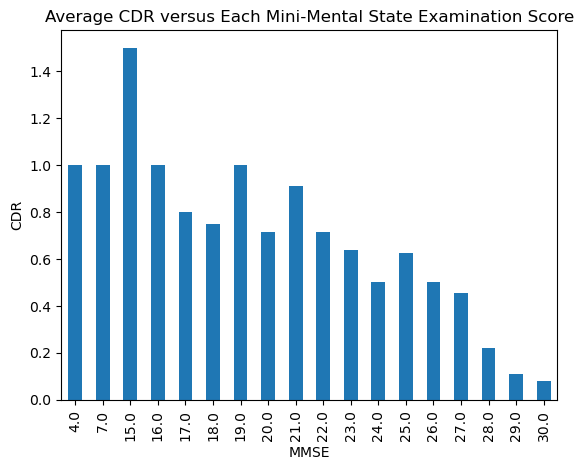

In [21]:
df.groupby('MMSE'). agg({'CDR': 'mean'}).plot.bar(legend=False);
plt.ylabel('CDR');
plt.title('Average CDR versus Each Mini-Mental State Examination Score');

#### 6. Relationship between Age and Group

We can see that there is a weak correlation between age and whether a person is demented or not. It appears that those who are demented are slightly younger than those who are nondemented and converted. This could be due to the fact that those who have dementia tend to die sooner than those without dementia. 

/Users/levys/y/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


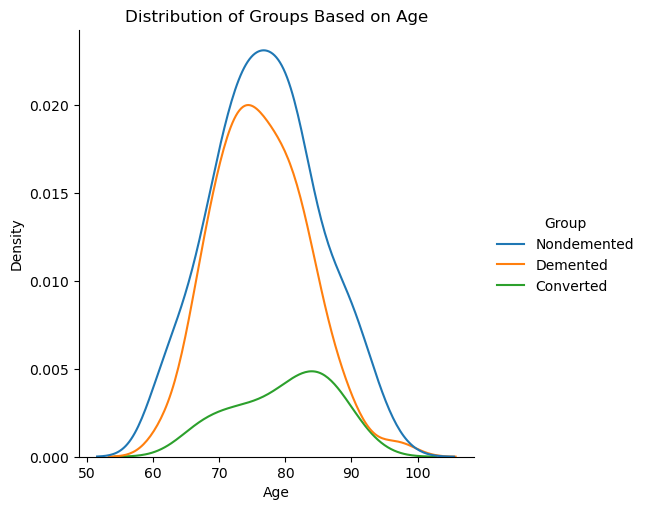

In [22]:
sns.displot(data=df, x='Age', hue='Group', kind="kde");
plt.title('Distribution of Groups Based on Age');

#### 7. Relationship between Education and Group

12 years to education corresponds to a high school graduate. Those who only graduated from high school are more likely to be demented than nondemented, whereas those with a college degree (16 years of education) are more likely to be nondemented than demented. This relationship holds especially true if the person received a graduate degree (18 years of education). 

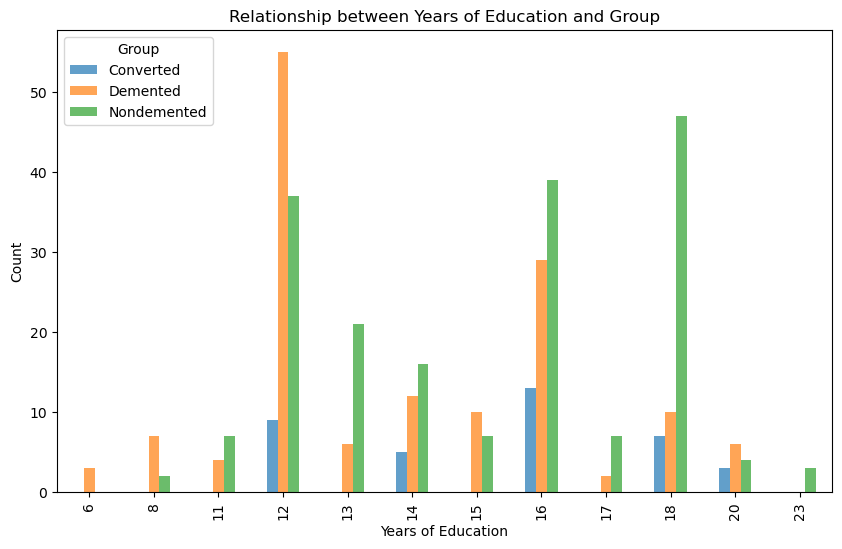

In [23]:
pivot_table = df.pivot_table(index='EDUC', columns='Group', aggfunc='size', fill_value=0)

pivot_table.plot(kind='bar', alpha=0.7, figsize=(10, 6))
plt.xlabel('Years of Education')
plt.ylabel('Count')
plt.title('Relationship between Years of Education and Group');

#### 8. Relationship between nWBV and CDR

Those who are demented and converted tend to have lower nWBV values than those who are nondemented. 

/Users/levys/y/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


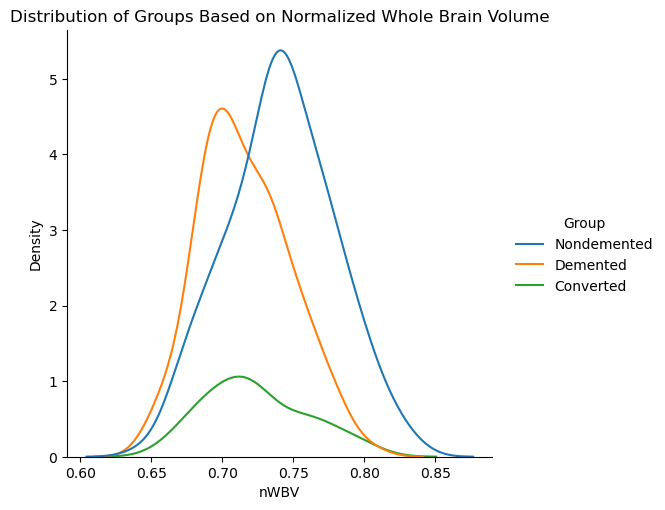

In [24]:
sns.displot(data=df, x='nWBV', hue='Group', kind="kde");
plt.title('Distribution of Groups Based on Normalized Whole Brain Volume');

#### 9. Relationship between Group and CDR

There is a clear class imbalance in the variable CDR. These classifications roughly correspond to Nondemented (0) through Demented (1.0). Only 3 scans were given a score of 2.0, which represented a more severe dementia. We plan to re-score those given a 2.0 as a 1.0 because we are interested in the presence of dementia more so than the severity of the dementia. One way we plan on handling this class imbalance is by using the binary variable we created for either ‘demented’ or not ‘demented.’ Additionally, we can use oversampling to have a more even split between the CDR values.

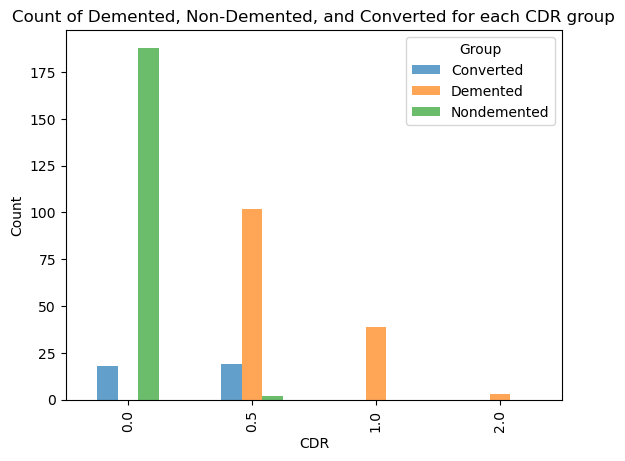

In [25]:
pivot_table = df.pivot_table(index='CDR', columns='Group', aggfunc='size', fill_value=0)

pivot_table.plot(kind='bar', alpha = 0.7)
plt.xlabel('CDR')
plt.ylabel('Count')
plt.title('Count of Demented, Non-Demented, and Converted for each CDR group');

#### 10. Class Imbalance - Demented 

There is a clear class imbalance in the variable Demented. 

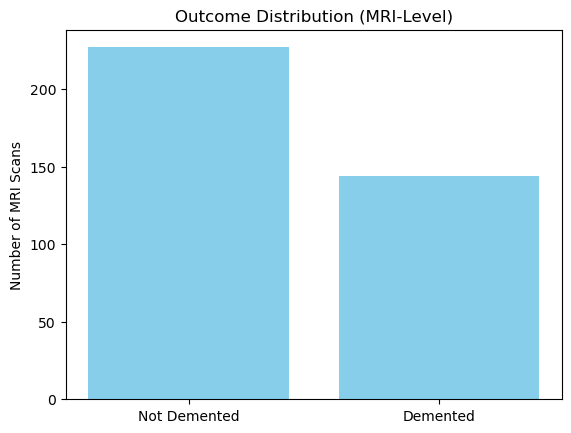

In [121]:
df_demented_counts = df['demented'].value_counts()
plt.bar(df_demented_counts.index, df_demented_counts, color='skyblue')
plt.ylabel('Number of MRI Scans')
plt.title('Outcome Distribution (MRI-Level)')
plt.xticks([0, 1], ['Not Demented', 'Demented'])
plt.show()

# Baseline Models <a name="baseline"></a>

As mentioned earlier, our dataset consists of 373 MRI imaging sessions of subjects. However, each subject accounts for at least 2 MRI imaging scans in the data. This means that although we have data for 373 MRI imaging sessions, we only have data for 150 subjects. Thus, the size of our data is relatively small.

It can pose a problem to create models that are trained on the full data set (all 373 MRI imaging scans) because several rows represent the scans of the same patient, just a year or more apart. It can be considered data leakage because the model may learn patterns in from one point in the time in the data that may not generalize well to another. For example, if a model learns specific characteristics from earlier scans that don't apply to later scans, it might perform poorly on new data. Additionally, there may be biased representation in the data if a certain subject has had 4 scans while another subject has only had 2.

Because of this, we plan on training our models on two data sets-- the original data set (373 MRI scans) and a data set that only contains a subject's latest scan. We will refer to them as the MRI-level data and the subject-level data, respectively.

### Create the MRI-level and Subject-level data splits

In [26]:
# Choose the baseline predictors we are going to use in our models 
baseline_predictors = ['Male', 'Age','EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
print("MRI-Level Data")
df[baseline_predictors + ['demented']].head()

MRI-Level Data


,Male,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,demented
0,1,87,14,2,27.0,1987,0.696,0.883,0
1,1,88,14,2,30.0,2004,0.681,0.876,0
2,1,75,12,2,23.0,1678,0.736,1.046,1
3,1,76,12,2,28.0,1738,0.713,1.010,1
4,1,80,12,2,22.0,1698,0.701,1.034,1


In [27]:
# Assess the class inbalance for MRI-Level Data
df['demented'].value_counts()

demented
0    227
1    144
Name: count, dtype: int64

#### MRI-level data

In [28]:
# Create the train-test split for the MRI-level data
# We decided to increase the test size to 0.3 since our dataset is so small 
X_train_mri, X_test_mri, y_train_mri, y_test_mri = train_test_split(df[baseline_predictors], df['demented'], 
                                                                    test_size=0.3, random_state=42, stratify=df['demented'])

In [29]:
#Scale the data so larger coefficents don't skew the models
scaler = StandardScaler()
X_train_scaled_mri = scaler.fit_transform(X_train_mri)
X_test_scaled_mri = scaler.transform(X_test_mri)

#### Subject-level data

In [30]:
# Group the data by subject ID
nested_list = [group.values for name, group in df.groupby('Subject ID')]

# Create the groups by subject id and keep only their last visit
subject_last_scan = [nested[-1] for nested in nested_list]
subject_level_df = pd.DataFrame(subject_last_scan, columns=df.columns)

# Create the train test split with a larger test size to adjust for the smaller dataset
# We also stratified to ensure that we have the same amount of demented in each split
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(subject_level_df[baseline_predictors], subject_level_df['demented'], 
                                                                    test_size=0.3, random_state=41, stratify=subject_level_df['demented'])

# Scale the data so larger coefficents don't skew the models
scaler = StandardScaler()
X_train_scaled_sub = scaler.fit_transform(X_train_sub)
X_test_scaled_sub = scaler.transform(X_test_sub)

In [31]:
# Choose the baseline predictors we are going to use in our models 
print("Subject-Level Data")
subject_level_df[baseline_predictors + ['demented']].head()

Subject-Level Data


,Male,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,demented
0,1,88,14,2,30.0,2004,0.681,0.876,0
1,1,80,12,2,22.0,1698,0.701,1.034,1
2,0,90,18,3,27.0,1200,0.718,1.462,0
3,1,85,12,4,30.0,1699,0.705,1.033,0
4,1,75,16,2,27.0,1372,0.710,1.279,1


In [32]:
# Assess the class inbalance for Subject-Level Data
subject_level_df['demented'].value_counts()

demented
0    86
1    64
Name: count, dtype: int64

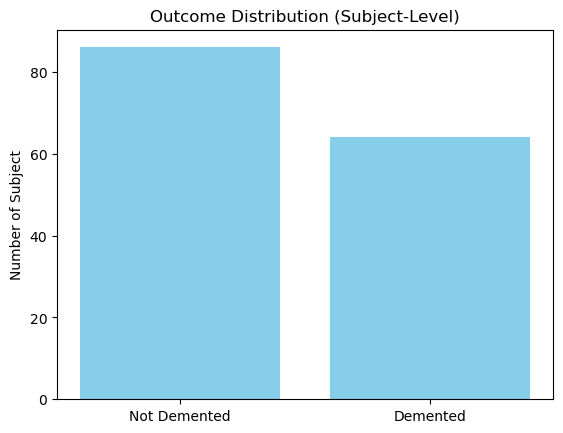

In [120]:
df_demented_counts = subject_level_df['demented'].value_counts()
plt.bar(df_demented_counts.index, df_demented_counts, color='skyblue')
plt.ylabel('Number of Subject')
plt.title('Outcome Distribution (Subject-Level)')
plt.xticks([0, 1], ['Not Demented', 'Demented'])
plt.show()

### Create the Baseline Logistic Regression Model (MRI-level Data) <a name="baseline_mri"></a>

In [33]:
#Fit baseline model using logistic regression with MRI-level data
baseline_model_mri = LogisticRegression(random_state = 42, max_iter = 1000, penalty = 'none').fit(X_train_scaled_mri, y_train_mri)

#Calculate the accuracies
baseline_train_acc = baseline_model_mri.score(X_train_scaled_mri, y_train_mri)
baseline_test_acc= baseline_model_mri.score(X_test_scaled_mri, y_test_mri)

#Calculate the f1 scores because of data inbalance 
y_pred_train_mri = baseline_model_mri.predict(X_train_scaled_mri)
y_pred_test_mri = baseline_model_mri.predict(X_test_scaled_mri)
f1_train= f1_score(y_train_mri, y_pred_train_mri)
f1_test = f1_score(y_test_mri, y_pred_test_mri)

print("\nCoefficient Values")
for i, coef in enumerate(baseline_model_mri.coef_[0]):
    print(baseline_predictors[i], coef)


Coefficient Values
Male 0.9200339309814611
Age -1.271060266424717
EDUC -0.7843786708131371
SES -0.3494853709542627
MMSE -3.577564592060709
eTIV 1.341162310624871
nWBV -0.9376274854693876
ASF 2.0272125817446853


The plot suggests that the most important predictors in the Baseline Logistic Model are MMSE, ASF, eTIV, and Age. Both MMSE and Age have a negative correlation with the presence of dementia while eTIV and ASF have a positive correlation with the presence of dementia. Note that these are based on MRI-level data. 

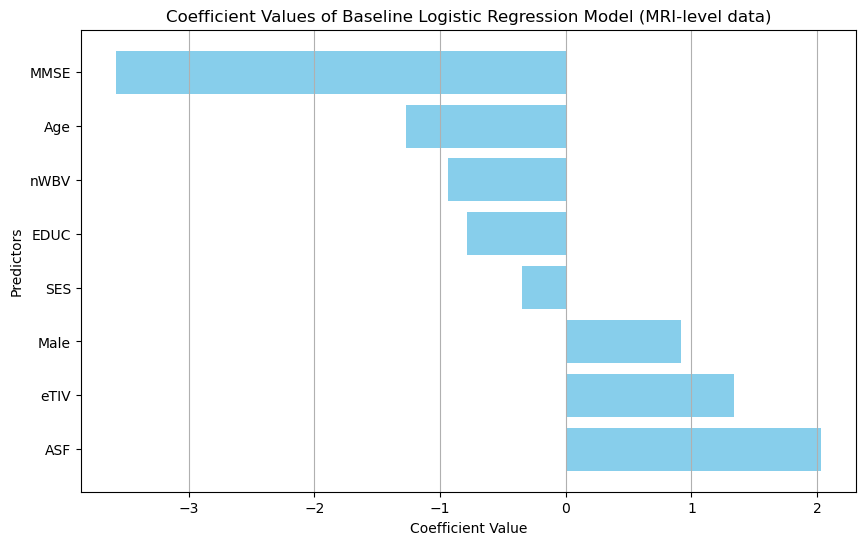

In [34]:
coefficients = baseline_model_mri.coef_[0]
coef_predictor_pairs = list(zip(coefficients, baseline_predictors))

coef_predictor_pairs.sort(reverse=True)
sorted_coefficients, sorted_predictors = zip(*coef_predictor_pairs)

plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Coefficient Values of Baseline Logistic Regression Model (MRI-level data)')
plt.grid(axis='x')
plt.show()

Note that since our dataset is imbalanced, we will be focusing on primarily scoring our models with the F1-score because this takes into account the precision and recall of the model. Our baseline logistic model (for MRI-level data) has a test F1 score of 0.73 and a train F1 score of 0.82. We can see that this model is slightly over-fitting to the training data as the test F1 score is lower than the train F1 score. We see similar overfitting with the accuracy scores.

In [35]:
#Create a dataframe that will hold all the MRI-level model results 
MODELS_mri = pd.DataFrame([['Baseline Logistic Regression', baseline_train_acc, baseline_test_acc, f1_train, f1_test]],  columns = ['Model', 'Train Accuracy Score', 'Test Accuracy Score', 'F1 Train Score', 'F1 Test Score'])
display(MODELS_mri)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Baseline Logistic Regression,0.864865,0.821429,0.816754,0.72973


These confusion matrices demonstrate that our baseline model is generally predicting the true classes. Additionally, these matricies highlight the small size of the train and test data. Because our data is so small, the accuracy and predictions have high variability.

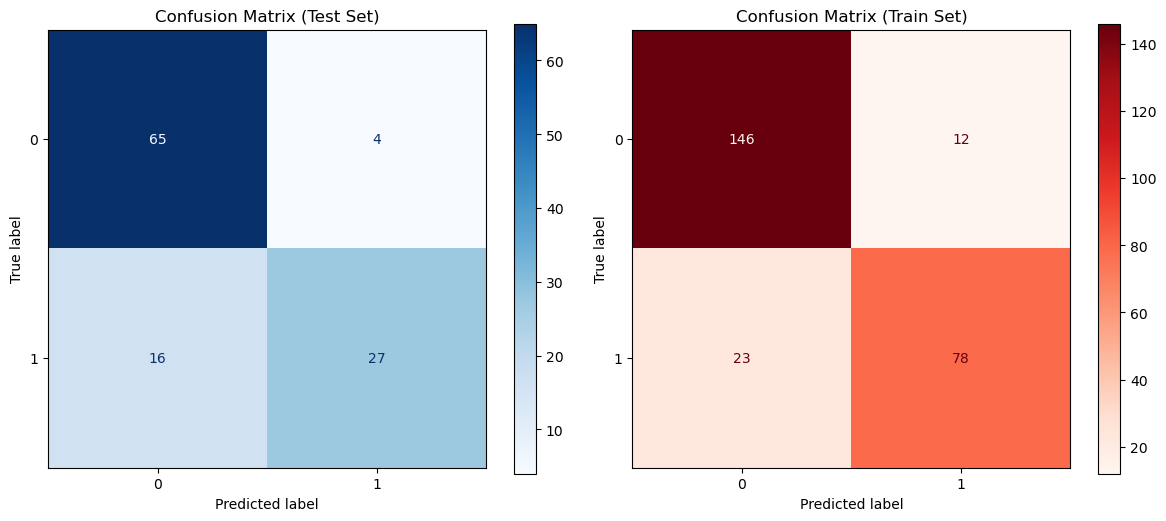

In [36]:
# Create a confusion matrix for the MRI-level logistic regression baseline model

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test Confusion Matrix
cm_test = confusion_matrix(y_test_mri, y_pred_test_mri, labels=baseline_model_mri.classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=baseline_model_mri.classes_)
disp_test.plot(cmap='Blues', ax=axes[0], values_format='.0f')
axes[0].set_title('Confusion Matrix (Test Set)')

# Train Confusion Matrix
cm_train = confusion_matrix(y_train_mri, y_pred_train_mri, labels=baseline_model_mri.classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=baseline_model_mri.classes_)
disp_train.plot(cmap='Reds', ax=axes[1], values_format='.0f')
axes[1].set_title('Confusion Matrix (Train Set)')

plt.tight_layout()
plt.show()

### Create the Baseline Logistic Regression Model (Subject-level Data) <a name="baseline_sub"></a>

In [37]:
baseline_model_subject = LogisticRegression(random_state = 42, max_iter = 1000, penalty = 'none').fit(X_train_scaled_sub, y_train_sub)

print("Accuracy on the Training Set", baseline_model_subject.score(X_train_scaled_sub, y_train_sub))
print("Accuracy on the Testing Set", baseline_model_subject.score(X_test_scaled_sub, y_test_sub))
y_pred_train_sub = baseline_model_subject.predict(X_train_scaled_sub)
y_pred_test_sub = baseline_model_subject.predict(X_test_scaled_sub)

print("F1 Score Train", f1_score(y_train_sub, y_pred_train_sub))
print("F1 Score Test", f1_score(y_test_sub, y_pred_test_sub))

print("\nCoefficient Values")
for i, coef in enumerate(baseline_model_subject.coef_[0]):
    print(baseline_predictors[i], coef)

Accuracy on the Training Set 0.8666666666666667
Accuracy on the Testing Set 0.7777777777777778
F1 Score Train 0.8444444444444444
F1 Score Test 0.7500000000000001

Coefficient Values
Male 1.5503511997766435
Age -1.5082548616482323
EDUC -0.7727063534109301
SES -0.10538207594857134
MMSE -3.6879736754140646
eTIV 1.4133829177190398
nWBV -0.6775429158151771
ASF 2.0095523963251654


The plot suggests that the most important predictors in the Baseline Logistic Model are MMSE, ASF, eTIV, and Age. Both MMSE and Age have a negative correlation with the presence of dementia while eTIV and ASF have a positive correlation with the presence of dementia. 
* As a person's score on the Mini Mental State examination (MMSE) increases by one standard deviation, the log odds of having dementia decreases by 3.69 standard deviations.
* As a person's age increases by one standard deviation, the log odds of having dementia decreases by 1.51 standard deviations.
* As a person's Atlas Scaling Factor (ASF) score increases by one standard deviation, the log odds of having dementia increases by 2.01 standard deviations.
* As a person's Estimated Total Intracranial Volume (eTIV) score increases by one standard deviation, the log odds of having dementia increases by 1.41 standard deviations.

Note that the top 4 logistic regression predictors in terms of coefficient magnitude are the same between the MRI-level and subject-level data.

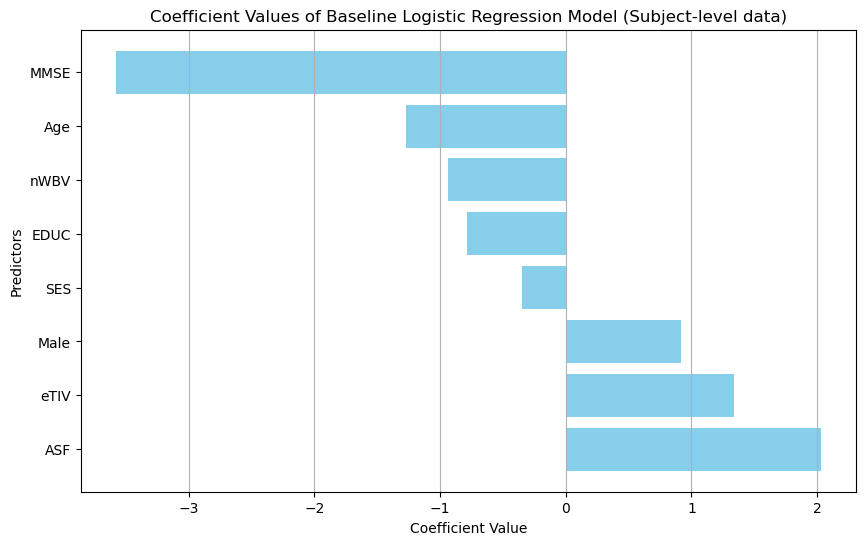

In [38]:
coefficients_sub = baseline_model_subject.coef_[0]
coef_predictor_pairs_sub = list(zip(coefficients_sub, baseline_predictors))

coef_predictor_pairs_sub.sort(reverse=True)
sorted_coefficients_sub, sorted_predictors_sub = zip(*coef_predictor_pairs_sub)

plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Coefficient Values of Baseline Logistic Regression Model (Subject-level data)')
plt.grid(axis='x')
plt.show()

Note that since our dataset is imbalanced, we will be focusing on primarily scoring our models with the F1-score because this takes into account the precision and recall of the model. Our baseline logistic model (for subject-level data) has a test F1 score of 0.75 and a train F1 score of 0.84. We can see that this model is slightly over-fitting to the training data as the test F1 score is lower than the train F1 score. We see similar overfitting with the accuracy scores.

In [39]:
#Create a dataframe that will hold all the Subject -level model results for future comparison

MODELS = pd.DataFrame([['Logistic Regression Baseline', baseline_model_subject.score(X_train_scaled_sub, y_train_sub), baseline_model_subject.score(X_test_scaled_sub, y_test_sub), f1_score(y_train_sub, y_pred_train_sub), f1_score(y_test_sub, y_pred_test_sub)]],  columns = ['Model', 'Train Accuracy Score', 'Test Accuracy Score', 'F1 Train Score', 'F1 Test Score'])
display(MODELS)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Logistic Regression Baseline,0.866667,0.777778,0.844444,0.75


These confusion matrices demonstrate that our baseline model for subject-level data is generally predicting the true classes. Additionally, these matricies highlight the small size of the train and test data. Because our data is so small, the accuracy and predictions have high variability.

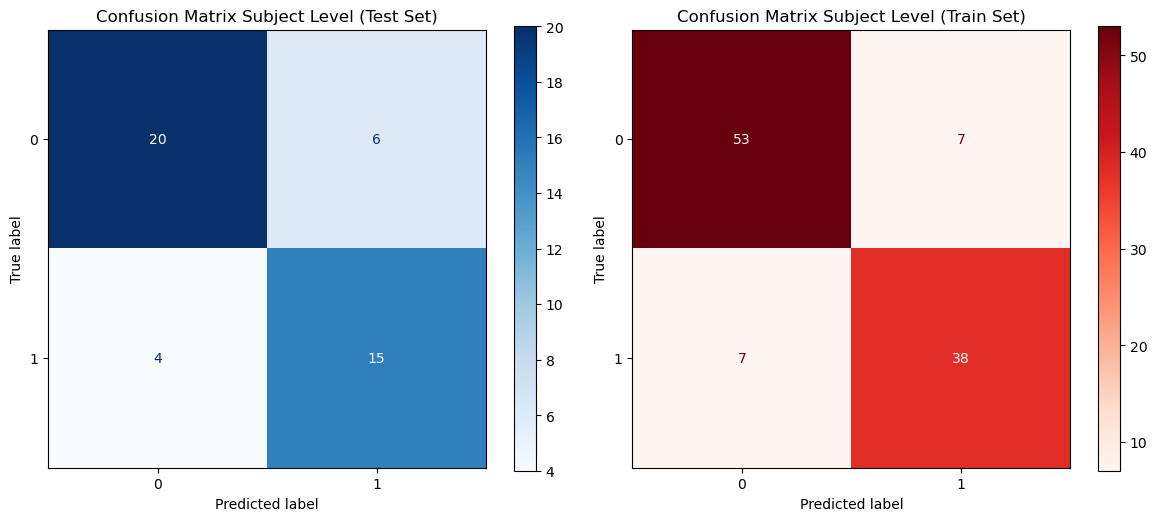

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Test Confusion Matrix
cm_test_sub = confusion_matrix(y_test_sub, y_pred_test_sub, labels=baseline_model_subject.classes_)
disp_test_sub = ConfusionMatrixDisplay(confusion_matrix=cm_test_sub, display_labels=baseline_model_subject.classes_)
disp_test_sub.plot(cmap='Blues', ax=axes[0], values_format='.0f')
axes[0].set_title('Confusion Matrix Subject Level (Test Set)')

# Train Confusion Matrix
cm_train_sub = confusion_matrix(y_train_sub, y_pred_train_sub, labels=baseline_model_subject.classes_)
disp_train_sub = ConfusionMatrixDisplay(confusion_matrix=cm_train_sub, display_labels=baseline_model_subject.classes_)
disp_train_sub.plot(cmap='Reds', ax=axes[1], values_format='.0f')
axes[1].set_title('Confusion Matrix Subject Level (Train Set)')

plt.tight_layout()
plt.show()

### Findings for Baseline Models (fix % values)

For our baseline model, we created 2 Logistic Regression models with the binary variable 'demented' as the outcome and the variables 'Male', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF' as our predictors. 

The data for the first logistic model (MRI-level) have one row per MRI scan so those with more scans are weighted more heavily in the dataset. This logistic model achieved a train accuracy of ~86%, test accuracy of ~82%, train F1-score of ~82%, and test F1-score of ~73%. 

The data for the second logistic model (Subject-level) have one row per subject, where we selected the most recent scan for each subject to avoid over-weighting subjects with more scans. This logistic model achieved a train accuracy of ~87%, test accuracy of ~78%, train F1-score of ~84%, and test F1-score of ~75%. We can see that this model is likely overfitting to the training set as the training accuracy and F1-score are much higher on the training set as compared to the testing set. 

Overall, the Subject-level model performed worse than the MRI-level model although we would prefer our model to have subject-level interpretations and not rely on having a subject with multiple scans. 

Our findings for both models suggest that the predictors with the largest coefficient values are: MMSE, Age, eTIV, and ASF. We can directly understand the relative importance of each predictor as the data is scaled before being used for the Logistic Regression.

We plan on exploring the following models: Baseline Logistic Regression, Regularized Logistic Regression, Decision Tree, Random Forest, XGBoost, Multi-layer Perceptron. Once we have created and trained all these models, we will compare their performance (F1-score). For all the models (except for XGBoost) we will handle the class imbalance by setting the class weight to be balanced.

# Tuning Models <a name="models"></a>

## Exploring Different Models using Subject-level data <a name="sub_models"></a>

### First Model: Regularized Logistic Regression <a name="sub_log"></a>

For our logistic regression model with regularization, we will scale our predictors and use 5-fold cross validation to find the best lasso regularization parameter for this model. 

In [41]:
# Fit a logistic regression model with different options for the lambda hyperparameter
Cs = np.logspace(-4, 4, 9)
max_iter = 1000
penalty = "l1"
solver = "liblinear"

logistic_lasso_sub = LogisticRegressionCV(Cs=Cs,
                                   cv=5,
                                   penalty=penalty,
                                   max_iter=max_iter,
                                   solver=solver,
                                   random_state=42, class_weight='balanced', scoring = 'f1'
)

#Fit to training data at subject level
logistic_lasso_sub = logistic_lasso_sub.fit(X_train_scaled_sub, y_train_sub)

# Use the best C value to train and fit the regularized logistic regression model
best_C = logistic_lasso_sub.C_[0]

logistic_lasso_sub = LogisticRegression(C = best_C, solver=solver, random_state=42, class_weight='balanced')
logistic_lasso_sub.fit(X_train_scaled_sub, y_train_sub)

#Predict and compute f1 scores
y_pred_train_logistic_lasso = logistic_lasso_sub.predict(X_train_scaled_sub)
y_pred_test_logistic_lasso = logistic_lasso_sub.predict(X_test_scaled_sub)
logistic_lasso_train_f1 = f1_score(y_train_sub, y_pred_train_logistic_lasso)
logistic_lasso_test_f1 = f1_score(y_test_sub, y_pred_test_logistic_lasso)

#calculate accuracy
logistic_lasso_train_acc = logistic_lasso_sub.score(X_train_scaled_sub, y_train_sub) 
logistic_lasso_test_acc = logistic_lasso_sub.score(X_test_scaled_sub, y_test_sub)

In [42]:
#append results to dataframe 
new_row_data = {
    'Model': 'Logistic Regression Lasso Regularized',
    'Train Accuracy Score': logistic_lasso_train_acc,  
    'Test Accuracy Score': logistic_lasso_test_acc,   
    'F1 Train Score': logistic_lasso_train_f1,       
    'F1 Test Score': logistic_lasso_test_f1         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS = pd.concat([MODELS, new_row_df], ignore_index=True)
display(MODELS)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Logistic Regression Baseline,0.866667,0.777778,0.844444,0.750000
1,Logistic Regression Lasso Regularized,0.847619,0.800000,0.826087,0.769231


Our logistic regression model with lasso regularization seems to perform slightly better on the test set than the baseline logistic model. The train accuracy for logistic regularized model is 0.848, which is 0.02 lower than our logistic lasso model. The test accuracy of the regularized logistic model is 0.8, which is a 0.3 increase from the baseline logistic model. Additionally, the regularized lasso model has a higher test F1 score (0.769) than the baseline logistic model (0.75). However, the regularized train F1 score (0.826) is slightly lower than for the baseline logistic model (0.844). We can see that the regularized logistic model is overfitting less than the baseline logistic model, allowing the regularized model to generalize better on the test set than the baseline model.

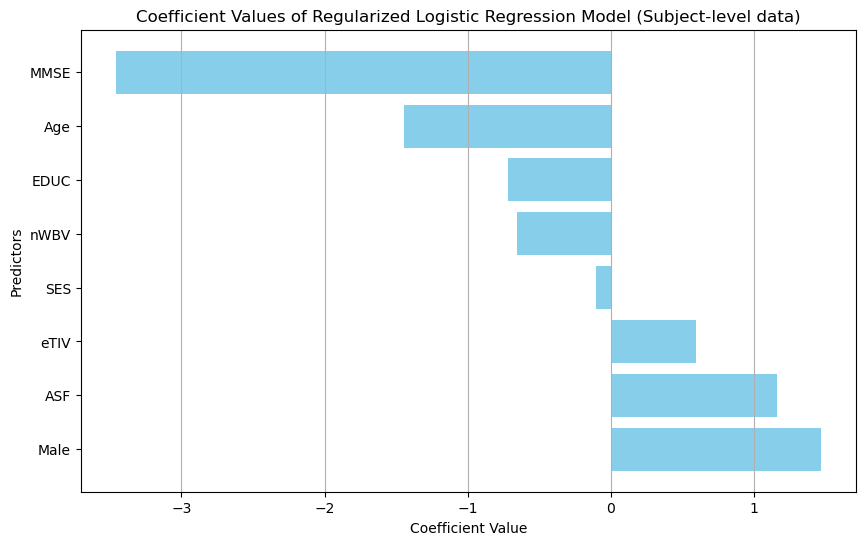

In [43]:
coefficients_sub_reg = logistic_lasso_sub.coef_[0]
coef_predictor_pairs_sub_reg = list(zip(coefficients_sub_reg, baseline_predictors))

coef_predictor_pairs_sub_reg.sort(reverse=True)
sorted_coefficients_sub_reg, sorted_predictors_sub_reg = zip(*coef_predictor_pairs_sub_reg)

plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors_sub_reg, sorted_coefficients_sub_reg, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Coefficient Values of Regularized Logistic Regression Model (Subject-level data)')
plt.grid(axis='x')
plt.show()

The plot above suggests that for the regularized logistic model, MMSE was the most significant predictor of the presence of dementia. The regularization seems to have reduced the coefficient values especially for eTIV and ASF as these predictors were much more significant in our baseline logistic model.  

### Second Model: Decision Tree <a name="sub_dt"></a>

Our next model is a decision tree for classification. We will perform a 5 fold cross validation from depths 1-20 to determine the best depth, and then fit a best depth tree on the entire training set. 

In [44]:
def calc_meanstd(X_train, y_train, depths, cv): # calculate the mean standard deviation for the trees
    cvmeans = []
    cvstds = []
    train_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        
        # calculate and append training F1 score
        clf.fit(X_train, y_train)
        train_pred = clf.predict(X_train)
        train_f1 = f1_score(y_train, train_pred, average='weighted') 
        train_scores.append(train_f1)
        
        # Perform cross validation and append mean and standard deviation to lists
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv, scoring='f1')
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    return cvmeans, cvstds, train_scores

def plot_cv_results(depths,cvmeans,cvstds,train_scores,title,limit_y=False,show_legend=True,): #plotting function to see the best tree depth
    plt.figure(figsize=(9, 4.5))
    plt.plot(depths,cvmeans,"^-",label="Mean validation",markeredgecolor="k",color="tab:orange",alpha=0.7,linewidth=2,)
    plt.fill_between(depths,cvmeans - 2*cvstds,cvmeans + 2*cvstds,color="tab:orange",alpha=0.3,label="Validation +/-2 standard deviations",)
    
    if limit_y:
        ylim = plt.ylim()
        plt.ylim(ylim)
    
    plt.plot(depths,train_scores,"o--",label="Training",color="tab:blue",alpha=0.4,linewidth=2,)

    if show_legend:
        plt.legend(fontsize=12)
    
    plt.ylabel("F1 Score", fontsize=12)
    plt.xlabel("Maximum tree depth", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(depths)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

In [81]:
# Run the decision tree cross validation
# set parameters for model fitting
depths = list(range(1, 21))
cv = 5

# perform CV and generate required results
cvmeans, cvstds, train_scores = calc_meanstd(X_train_sub, y_train_sub, depths, cv)

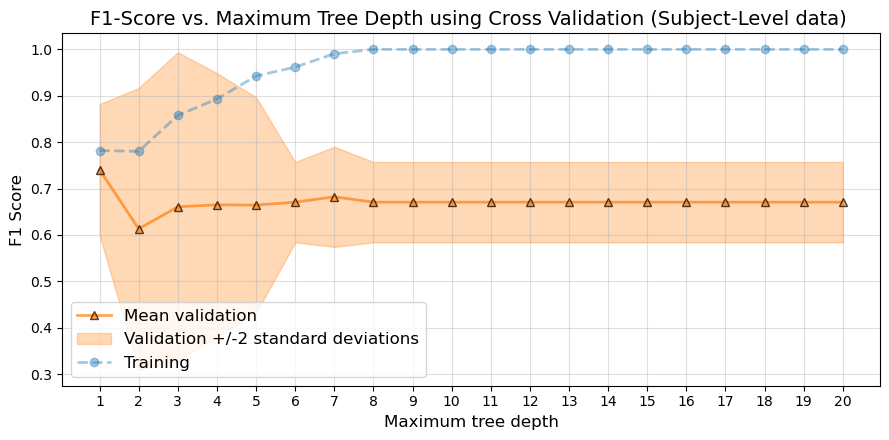

In [82]:
# convert results from lists to arrays for plotting function
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plot results as full plot
title = (    "F1-Score vs. Maximum Tree Depth using Cross Validation (Subject-Level data) ")
plot_cv_results(depths,cvmeans,cvstds,train_scores,title,limit_y=False,show_legend=True,)

The wide confidence intervals here indicate that the model is highly variable because there is such little data in each fold for cross validation.  We cannot say definitively that the max depth of 1 performs the best because the confidence intervals are so wide. We do see a plateau in f1 validation scores.

In [47]:
#Identify the best depth by finding the max cross validation mean
best_tree_depth_index = np.argmax(cvmeans)
#Set the depth to the best depth
depth = depths[best_tree_depth_index]

In [48]:
#Fit a decision tree at the best depth 
dt_best_depth_sub = DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight='balanced')
dt_best_depth_sub.fit(X_train_scaled_sub, y_train_sub)

#Predict from tree
dt_pred_train = dt_best_depth_sub.predict(X_train_scaled_sub)
dt_pred_test = dt_best_depth_sub.predict(X_test_scaled_sub)

dt_train_acc = dt_best_depth_sub.score(X_train_scaled_sub, y_train_sub)
dt_test_acc = dt_best_depth_sub.score(X_test_scaled_sub, y_test_sub)

dt_train_f1 = f1_score(y_train_sub, dt_pred_train)
dt_test_f1 = f1_score(y_test_sub, dt_pred_test)

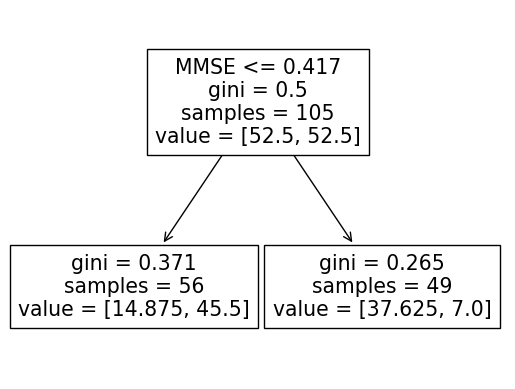

In [49]:
plot_tree(dt_best_depth_sub, feature_names=baseline_predictors);

The above decision tree (stump) shows that if we can only make one split in the data, we will split at an MMSE value of 0.417 (this is a scaled MMSE value).

In [50]:
new_row_data = {
    'Model': f'Decision Tree Best Depth = {depth}',
    'Train Accuracy Score': dt_train_acc,  
    'Test Accuracy Score': dt_test_acc,   
    'F1 Train Score': dt_train_f1,       
    'F1 Test Score': logistic_lasso_test_f1         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS = pd.concat([MODELS, new_row_df], ignore_index=True)
display(MODELS)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Logistic Regression Baseline,0.866667,0.777778,0.844444,0.750000
1,Logistic Regression Lasso Regularized,0.847619,0.800000,0.826087,0.769231
2,Decision Tree Best Depth = 1,0.780952,0.800000,0.772277,0.769231


The decision tree model with a best depth of 1 has a lower F1 train score than both previous models but has the same F1 test score as the regularized logistic model. This means that decision tree is overfitting less than both of the previous models.

### Third Model: Tuned Random Forest <a name="sub_rf"></a>

In [51]:
#Random forest with tuning 
# Use grid search to find the best minimum samples to split on and maximum features
rf_tuned = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                  param_grid={'min_samples_split': [2,3,4,5,6,7],
                              'max_features': [2,3,4,5, 6, 7]},         
                  cv=5,
                  scoring = 'f1')
rf_tuned.fit(X_train_scaled_sub, y_train_sub)

best_max_features = rf_tuned.best_params_['max_features']
best_min_samples = rf_tuned.best_params_['min_samples_split']
print(rf_tuned.best_params_)

{'max_features': 5, 'min_samples_split': 5}


We will now train a random forest model with 5 max_features and 3 min_samples_split as the parameters.

In [52]:
# Fit a random forest classifier with the best parameters from the grid search above
rf_best_hyperparameters_sub = RandomForestClassifier(random_state = 42, max_features=best_max_features, min_samples_split=best_min_samples, class_weight='balanced')
rf_best_hyperparameters_sub.fit(X_train_scaled_sub,y_train_sub)
rf_tuned_train_score = rf_best_hyperparameters_sub.score(X_train_scaled_sub, y_train_sub) 
rf_tuned_test_score = rf_best_hyperparameters_sub.score(X_test_scaled_sub, y_test_sub)
rf_train_pred = rf_best_hyperparameters_sub.predict(X_train_scaled_sub)
rf_test_pred = rf_best_hyperparameters_sub.predict(X_test_scaled_sub)
f1_rf_tune_train_score = f1_score(y_train_sub, rf_train_pred)
f1_rf_tune_test_score = f1_score(y_test_sub, rf_test_pred)

In [53]:
# Add random forest accuracy/F1 scores to the results table
new_row_data = {
    'Model': 'Tuned Random Forest',
    'Train Accuracy Score': rf_tuned_train_score,  
    'Test Accuracy Score': rf_tuned_test_score,   
    'F1 Train Score': f1_rf_tune_train_score,       
    'F1 Test Score': f1_rf_tune_test_score         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS = pd.concat([MODELS, new_row_df], ignore_index=True)
display(MODELS)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Logistic Regression Baseline,0.866667,0.777778,0.844444,0.750000
1,Logistic Regression Lasso Regularized,0.847619,0.800000,0.826087,0.769231
2,Decision Tree Best Depth = 1,0.780952,0.800000,0.772277,0.769231
3,Tuned Random Forest,0.961905,0.822222,0.955556,0.789474


The tuned random forest model has a much higher F1 train score than any of the previous models, but has a slightly higher F1 test score compared to the others. This means that the random forest is overfitting significantly to the training data but still manages to generalize better on the testing data.

In [54]:
num_features = range(len(baseline_predictors))
top_predictors_rf = {key: 0 for key in num_features}

# random forest
trees = rf_best_hyperparameters_sub.estimators_
for tree in trees:
    top_node = tree.tree_.feature[0]
    top_predictors_rf[top_node] += 1

top_predictors_rf = pd.DataFrame(list(top_predictors_rf.items()), columns=['Feature', 'Count'])
column_names = baseline_predictors
top_predictors_rf.drop(columns=['Feature'], inplace=True, errors='ignore')
top_predictors_rf.insert(0, 'Feature', column_names)
top_predictors_rf

,Feature,Count
0,Male,10
1,Age,10
2,EDUC,6
3,SES,3
4,MMSE,59
5,eTIV,1
6,nWBV,11
7,ASF,0


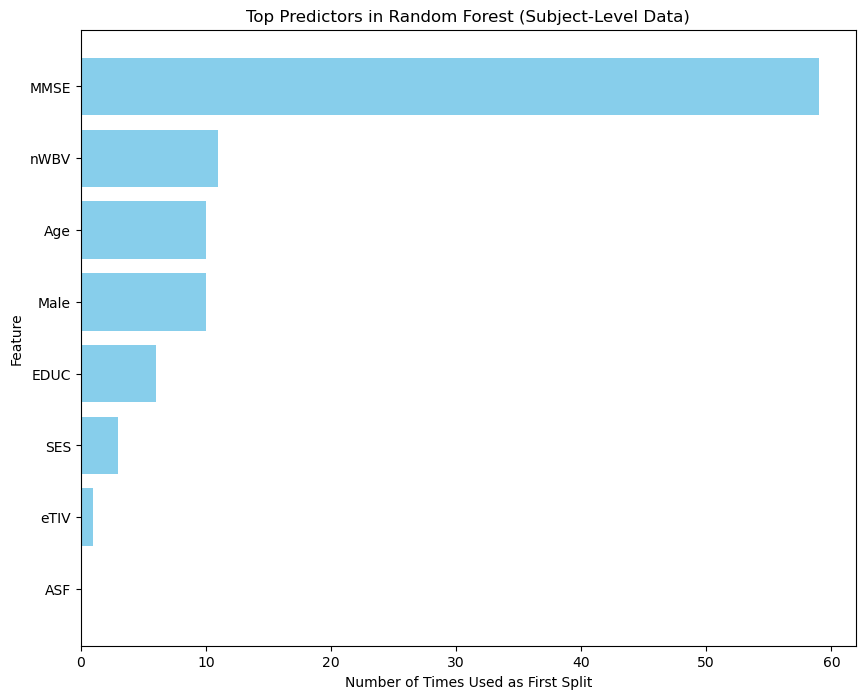

In [69]:
top_predictors_rf = top_predictors_rf.sort_values(by='Count', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_predictors_rf.Feature, top_predictors_rf.Count, color='skyblue')
plt.xlabel('Number of Times Used as First Split')
plt.ylabel('Feature')
plt.title('Top Predictors in Random Forest (Subject-Level Data)')
plt.show()

The table and the plot indicate that the feature that was primarily used as the first split in the random forest is MMSE. This is not surprising because the decision tree model, if only allowed a single split, prioritized MMSE.

### Fourth Model: Tuned XGBoost <a name="sub_xg"></a>

In [57]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier()
parameters = {'max_depth':[1,2,3], 'n_estimators':[100, 150, 200, 250, 300, 400], 'learning_rate': [0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001]}
xgb_tuning = GridSearchCV(xgb_model, parameters, cv=5, n_jobs=-1, scoring='f1')
xgb_tuning.fit(X_train_scaled_sub, y_train_sub)

print(xgb_tuning.best_params_)

# Create a XGBoost model with the best parameters
xgb_model_sub = xgb.XGBClassifier(
    max_depth=xgb_tuning.best_params_['max_depth'],
    n_estimators=xgb_tuning.best_params_['n_estimators'],
    learning_rate=xgb_tuning.best_params_['learning_rate'], random_state=42)

# Fit the XGBoost model on the training data
xgb_model_sub.fit(X_train_scaled_sub, y_train_sub)

xgb_train_score = xgb_model_sub.score(X_train_scaled_sub, y_train_sub)
xgb_test_score = xgb_model_sub.score(X_test_scaled_sub, y_test_sub)
y_train_pred = xgb_model_sub.predict(X_train_scaled_sub)
y_test_pred = xgb_model_sub.predict(X_test_scaled_sub)
f1_train_score = f1_score(y_train_sub, y_train_pred)
f1_test_score = f1_score(y_test_sub, y_test_pred)

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}


In [58]:
print(baseline_predictors)

['Male', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']


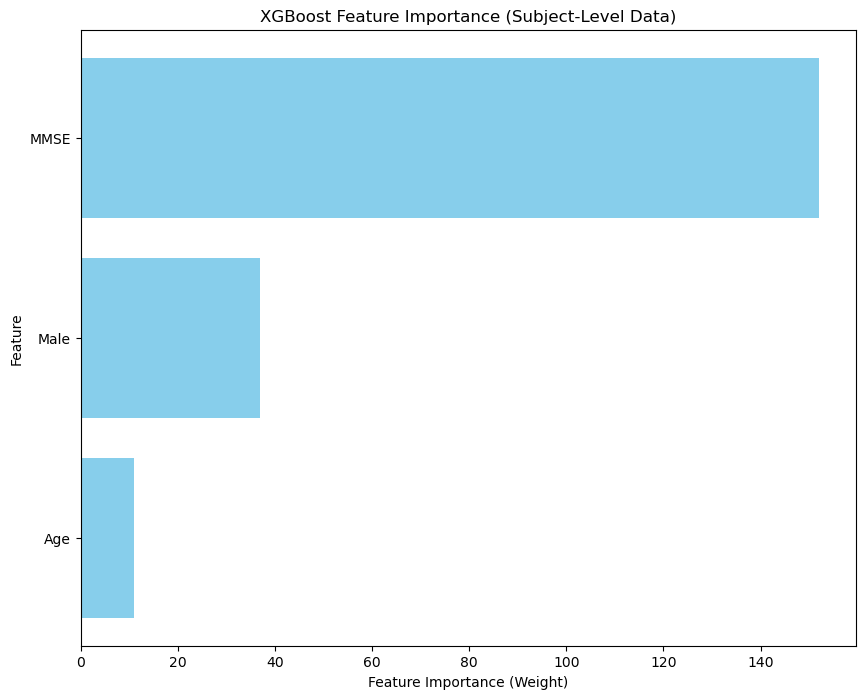

In [108]:
importance = xgb_model_sub.get_booster().get_score(importance_type='weight')
features = list(importance.keys())
importance_scores = list(importance.values())

# Sort features and importance scores in descending order
sorted_indices = sorted(range(len(importance_scores)), key=lambda k: importance_scores[k], reverse=False)
sorted_features = [features[i] for i in sorted_indices]
sorted_importance_scores = [importance_scores[i] for i in sorted_indices]

feature_labels = {'f0': 'Male', 'f1': 'Age', 'f2': 'EDUC', 'f3': 'SES', 'f4': 'MMSE', 'f5': 'eTIV', 'f6': 'nWBV', 'f7': 'ASF'}  

plt.figure(figsize=(10, 8))
plt.barh([feature_labels.get(f, f) for f in sorted_features], sorted_importance_scores, color='skyblue')
plt.xlabel('Feature Importance (Weight)')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (Subject-Level Data)')
plt.show()


We trained a XGBoost model with a learning rate of 0.01, a max depth of 1, and 200 estimators. The most-used feature for splitting was MMSE, which supports the findings of the previous models. Only 2 other features were used for splitting, which were Age and Male. The other models did not prioritize these predictors as much as  XGBoost did.

In [60]:
# Save the XGBoost results in the result table
new_row_data = {
    'Model': 'Tuned XGBoost',
    'Train Accuracy Score': xgb_train_score,  
    'Test Accuracy Score': xgb_test_score,   
    'F1 Train Score': f1_train_score,       
    'F1 Test Score': f1_test_score         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS = pd.concat([MODELS, new_row_df], ignore_index=True)
display(MODELS)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Logistic Regression Baseline,0.866667,0.777778,0.844444,0.750000
1,Logistic Regression Lasso Regularized,0.847619,0.800000,0.826087,0.769231
2,Decision Tree Best Depth = 1,0.780952,0.800000,0.772277,0.769231
3,Tuned Random Forest,0.961905,0.822222,0.955556,0.789474
4,Tuned XGBoost,0.838095,0.822222,0.800000,0.777778


The XGBoost has a higher F1 test score than the decision tree and both logistic regression models but a lower F1 train score than the logistic models and random forest. XGBoost is overfitting less than random forest and achieving a comparable test score.

### Fifth Model: Tuned Multi-Layer Perceptron Neural Network <a name="sub_nn"></a>

In [61]:
# Create parameter grid for Multi-Layer Perceptron Neural Network (209 model)
param_grid = {
    'hidden_layer_sizes': [(8, 4),(30, 10),(12, 8, 4),(50, 25, 10),
    (20, 20, 20),
    (15, 15, 15, 15),
],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    
}

# Create an MLPClassifier instance
neural_network = MLPClassifier(random_state=42, max_iter=10000)


# Perform GridSearchCV
grid_search = GridSearchCV(neural_network, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled_sub, y_train_sub)

# Get the best parameters and best score
best_hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']
best_activation = grid_search.best_params_['activation']
best_alpha = grid_search.best_params_['alpha']
best_learning_rate = grid_search.best_params_['learning_rate']


# Train a neural network based on the best parameters
best_neural_network_sub = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, activation = best_activation,
                                    alpha = best_alpha, learning_rate = best_learning_rate, random_state=42, max_iter=10000)
best_neural_network_sub.fit(X_train_scaled_sub, y_train_sub)

train_accuracy = best_neural_network_sub.score(X_train_scaled_sub, y_train_sub)
test_accuracy = best_neural_network_sub.score(X_test_scaled_sub, y_test_sub)

y_pred_train = best_neural_network_sub.predict(X_train_scaled_sub)
y_pred_test = best_neural_network_sub.predict(X_test_scaled_sub)

f1_train = f1_score(y_train_sub, y_pred_train)
f1_test = f1_score(y_test_sub, y_pred_test)

In [62]:
best_hidden_layer_sizes = grid_search.best_params_
best_hidden_layer_sizes

{'activation': 'logistic',
 'alpha': 0.1,
 'hidden_layer_sizes': (30, 10),
 'learning_rate': 'constant'}

We used the above features to create the multi-layer perceptron network.

In [63]:
# Add neural network results to the results table
new_row_data = {
    'Model': 'Tuned Multi-Layer Perceptron NN',
    'Train Accuracy Score': train_accuracy,  
    'Test Accuracy Score': test_accuracy,   
    'F1 Train Score': f1_train,       
    'F1 Test Score': f1_test         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS = pd.concat([MODELS, new_row_df], ignore_index=True)
display(MODELS)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Logistic Regression Baseline,0.866667,0.777778,0.844444,0.750000
1,Logistic Regression Lasso Regularized,0.847619,0.800000,0.826087,0.769231
2,Decision Tree Best Depth = 1,0.780952,0.800000,0.772277,0.769231
3,Tuned Random Forest,0.961905,0.822222,0.955556,0.789474
4,Tuned XGBoost,0.838095,0.822222,0.800000,0.777778
5,Tuned Multi-Layer Perceptron NN,0.866667,0.800000,0.844444,0.769231


The multi-layer perceptron neural network had the same train F1 score as the baseline logistic regression model and a slightly higher F1 test score. Overall, the F1 test score of the neural network is lower than the random forest and XGboost models but higher than the others. 

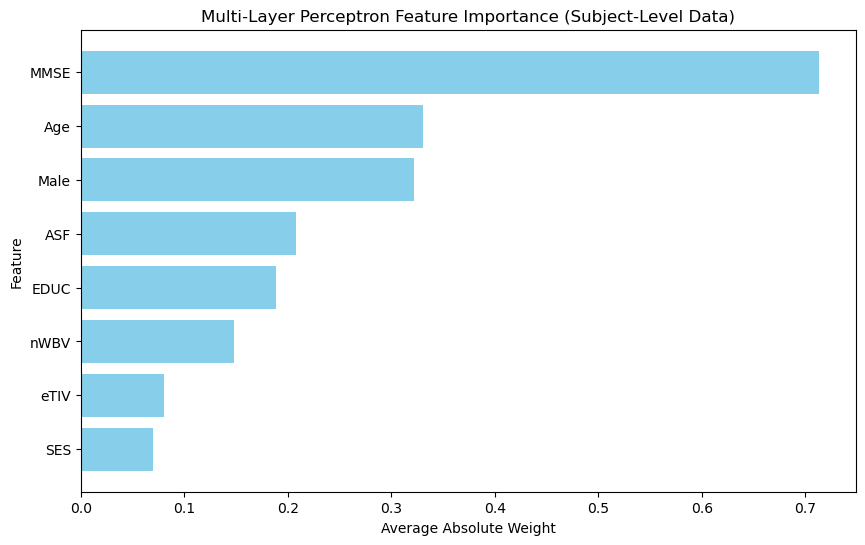

In [67]:
# Calculate the mean of the coefficient weights
weights = best_neural_network_sub.coefs_[0]
mean_abs_weights = np.abs(weights).mean(axis=1)

# Sort feature importance by mean absolute weight in ascending order
sorted_indices = np.argsort(mean_abs_weights)
sorted_baseline_predictors = [baseline_predictors[i] for i in sorted_indices]
sorted_weights = mean_abs_weights[sorted_indices]

# Plotting with sorted feature names as y-axis labels
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_weights)), sorted_weights, color = 'skyblue')
plt.xlabel('Average Absolute Weight')
plt.ylabel('Feature')
plt.yticks(range(len(sorted_weights)), sorted_baseline_predictors)  
plt.title('Multi-Layer Perceptron Feature Importance (Subject-Level Data)')
plt.show()

On average, MMSE, age, and male were given the highest weights throughout the Multi-Layer Perceptron. All of our models have been prioritizing MMSE above all other predictors, indicating that it is an important feature for classifying the presence of dementia.

## Exploring Different Models using MRI-level data <a name="mri_models"></a>

Now we will be exploring how different models perform on the MRI-level data.

### First Model: Regularized Logistic Regression <a name="mri_log"></a>

In [70]:
# Fit a logistic regression model with different options for the lambda hyperparameter
Cs = np.logspace(-4, 4, 9)
max_iter = 1000
penalty = "l1"
solver = "liblinear" # we choose liblinear because it works well for small datasets

logistic_lasso_mri = LogisticRegressionCV(Cs=Cs,
                                   cv=5, # low cv value because our data set is small
                                   penalty=penalty,
                                   max_iter=max_iter,
                                   solver=solver,
                                   random_state=42,
                                class_weight='balanced', scoring='f1'
)

#Fit to training data at subject level
logistic_lasso_mri = logistic_lasso_mri.fit(X_train_scaled_mri, y_train_mri)

# Use the best C value to train and fit the regularized logistic regression model
best_C = logistic_lasso_mri.C_[0]

logistic_lasso_mri = LogisticRegression(C = best_C, solver=solver, random_state=42, class_weight='balanced')
logistic_lasso_mri.fit(X_train_scaled_mri, y_train_mri)

y_pred_train_logistic_lasso = logistic_lasso_mri.predict(X_train_scaled_mri)
y_pred_test_logistic_lasso = logistic_lasso_mri.predict(X_test_scaled_mri)

logistic_lasso_train_f1 = f1_score(y_train_mri, y_pred_train_logistic_lasso)
logistic_lasso_test_f1 = f1_score(y_test_mri, y_pred_test_logistic_lasso)

logistic_lasso_train_acc = logistic_lasso_mri.score(X_train_scaled_mri, y_train_mri) 
logistic_lasso_test_acc = logistic_lasso_mri.score(X_test_scaled_mri, y_test_mri)


In [71]:
new_row_data = {
    'Model': 'Logistic Regression with Lasso Regularization',
    'Train Accuracy Score': logistic_lasso_train_acc,  
    'Test Accuracy Score': logistic_lasso_test_acc,   
    'F1 Train Score': logistic_lasso_train_f1,       
    'F1 Test Score': logistic_lasso_test_f1         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS_mri = pd.concat([MODELS_mri, new_row_df], ignore_index=True)
display(MODELS_mri)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Baseline Logistic Regression,0.864865,0.821429,0.816754,0.729730
1,Logistic Regression with Lasso Regularization,0.861004,0.857143,0.821782,0.809524


The logistic regression with lasso regularization has a higher F1 test score than the baseline logistic model and comparable F1 train scores. This suggests that this model is not overfitting the training data as much as the baseline model.

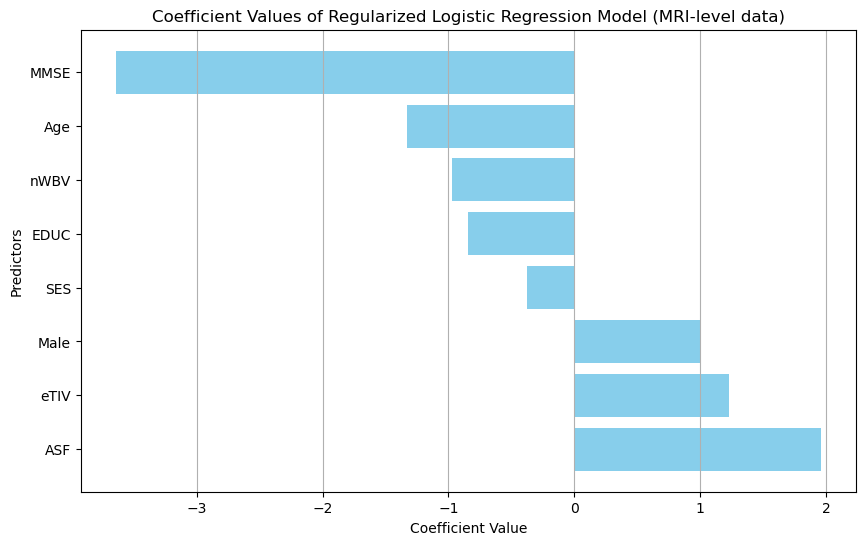

In [72]:
coefficients_mri_reg = logistic_lasso_mri.coef_[0]
coef_predictor_pairs_mri_reg = list(zip(coefficients_mri_reg, baseline_predictors))

coef_predictor_pairs_mri_reg.sort(reverse=True)
sorted_coefficients_mri_reg, sorted_predictors_mri_reg = zip(*coef_predictor_pairs_mri_reg)

plt.figure(figsize=(10, 6))
plt.barh(sorted_predictors_mri_reg, sorted_coefficients_mri_reg, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.title('Coefficient Values of Regularized Logistic Regression Model (MRI-level data)')
plt.grid(axis='x')
plt.show()

The plot above suggests that for the regularized logistic model, MMSE was the most significant predictor of the presence of dementia. This model still has the same four most significant predictors as our baseline logistic model (MMSE, Age, eTIV, ASF) and the regularization did not shrink the coefficients much.

### Second Model: Decision Tree <a name="mri_dt"></a>

Our next model is a decision tree for classification. We will perform a 5 fold cross validation from depths 1-20 to determine the best depth, and then fit a best depth tree on the entire training set.

In [73]:
depths = list(range(1, 21))
cv = 5
cvmeans = []
cvstds = []
train_scores = []

for depth in depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight='balanced')
    train_scores.append(dt_clf.fit(X_train_scaled_mri, y_train_mri).score(X_train_scaled_mri, y_train_mri))

    scores = cross_val_score(estimator=dt_clf, X=X_train_scaled_mri, y=y_train_mri, cv=cv)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

In [74]:
best_tree_depth_index = np.argmax(cvmeans)
depth = depths[best_tree_depth_index]

In [75]:
depth

1

In [76]:
dt_best_depth_mri = DecisionTreeClassifier(max_depth=depth, random_state=42)
dt_best_depth_mri.fit(X_train_scaled_mri, y_train_mri)

dt_pred_train = dt_best_depth_mri.predict(X_train_scaled_mri)
dt_pred_test = dt_best_depth_mri.predict(X_test_scaled_mri)

dt_train_acc = dt_best_depth_mri.score(X_train_scaled_mri, y_train_mri)
dt_test_acc = dt_best_depth_mri.score(X_test_scaled_mri, y_test_mri)

dt_train_f1 = f1_score(y_train_mri, dt_pred_train)
dt_test_f1 = f1_score(y_test_mri, dt_pred_test)

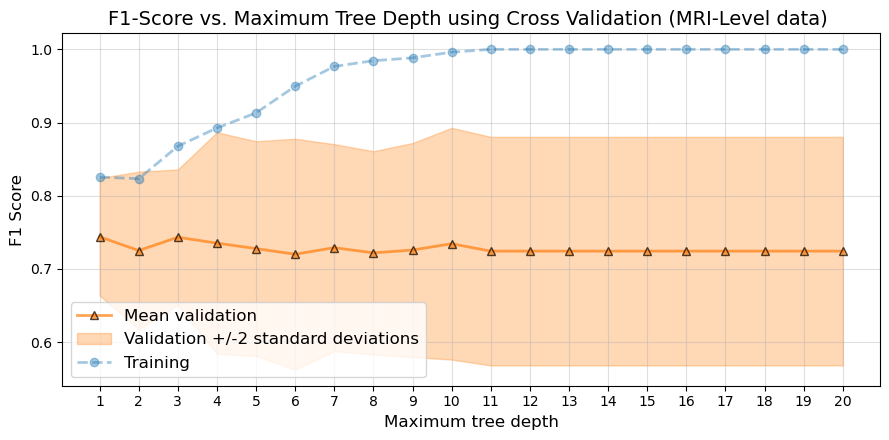

In [83]:
# convert results from lists to arrays for plotting function

cvmeans, cvstds, train_scores = calc_meanstd(X_train_mri, y_train_mri, depths, cv)

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plot results as full plot
title = (
    "F1-Score vs. Maximum Tree Depth using Cross Validation (MRI-Level data) "
)
plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
)


The wide confidence intervals here indicate that the model is highly variable because there is such little data in each fold for cross validation. We cannot say definitively that the max depth of 1 performs the best because the confidence intervals are so wide. We do see a plateau in f1 validation scores as depth increases.

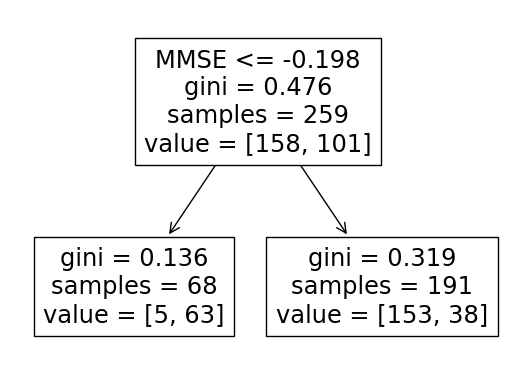

In [84]:
plot_tree(dt_best_depth_mri, feature_names=baseline_predictors);

The above decision tree (stump) shows that if we can only make one split in the data, we will split at an MMSE value of -0.198 (this is a scaled MMSE value).

In [85]:
new_row_data = {
    'Model': f'Decision Tree Best Depth = {depth}',
    'Train Accuracy Score': dt_train_acc,  
    'Test Accuracy Score': dt_test_acc,   
    'F1 Train Score': dt_train_f1,       
    'F1 Test Score': dt_test_f1         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS_mri = pd.concat([MODELS_mri, new_row_df], ignore_index=True)
display(MODELS_mri)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Baseline Logistic Regression,0.864865,0.821429,0.816754,0.729730
1,Logistic Regression with Lasso Regularization,0.861004,0.857143,0.821782,0.809524
2,Decision Tree Best Depth = 1,0.833977,0.803571,0.745562,0.656250


The decision tree model with a best depth of 1 has a lower F1 train and test score compared to the previous models.

### Third Model: Random Forest <a name="mri_rf"></a>

In [86]:
# Use cross validation to find the best hyper parameters for the random forest
rf_tuned = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                  param_grid={'min_samples_split': [6,7,8,9,10,11,12,13,14],
                              'max_features': [1, 2,3,4,5]},         
                  cv=5, scoring='f1')
rf_tuned.fit(X_train_scaled_mri, y_train_mri)

best_max_features = rf_tuned.best_params_['max_features']
best_min_samples = rf_tuned.best_params_['min_samples_split']

In [87]:
print(rf_tuned.best_params_)

{'max_features': 2, 'min_samples_split': 10}


We will now train a random forest model with 2 max_features and 10 min_samples_split as the parameters.

In [88]:
rf_best_hyperparameters_mri = RandomForestClassifier(random_state = 42, max_features=best_max_features, min_samples_split=best_min_samples, class_weight='balanced')

rf_best_hyperparameters_mri.fit(X_train_scaled_mri,y_train_mri)
rf_tuned_train_score = rf_best_hyperparameters_mri.score(X_train_scaled_mri, y_train_mri) 
rf_tuned_test_score = rf_best_hyperparameters_mri.score(X_test_scaled_mri, y_test_mri)

rf_train_pred = rf_best_hyperparameters_mri.predict(X_train_scaled_mri)
rf_test_pred = rf_best_hyperparameters_mri.predict(X_test_scaled_mri)

f1_rf_tune_train_score = f1_score(y_train_mri, rf_train_pred)
f1_rf_tune_test_score = f1_score(y_test_mri, rf_test_pred)

In [89]:
new_row_data = {
    'Model': 'Tuned Random Forest',
    'Train Accuracy Score': rf_tuned_train_score,  
    'Test Accuracy Score': rf_tuned_test_score,   
    'F1 Train Score': f1_rf_tune_train_score,       
    'F1 Test Score': f1_rf_tune_test_score         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS_mri = pd.concat([MODELS_mri, new_row_df], ignore_index=True)
display(MODELS_mri)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Baseline Logistic Regression,0.864865,0.821429,0.816754,0.729730
1,Logistic Regression with Lasso Regularization,0.861004,0.857143,0.821782,0.809524
2,Decision Tree Best Depth = 1,0.833977,0.803571,0.745562,0.656250
3,Tuned Random Forest,0.957529,0.901786,0.945274,0.867470


The random forest model had a higher F1 train and test score than all previous models. Currently, this is our highest performing model for the MRI-level data.

In [90]:
num_features_mri = range(len(baseline_predictors))
top_predictors_rf_mri = {key: 0 for key in num_features_mri}

trees_mri = rf_best_hyperparameters_mri.estimators_
for tree in trees_mri:
    top_node = tree.tree_.feature[0]
    top_predictors_rf_mri[top_node] += 1


top_predictors_rf_mri = pd.DataFrame(list(top_predictors_rf_mri.items()), columns=['Feature','Count'])
top_predictors_rf_mri.index = baseline_predictors
top_predictors_rf_mri.drop(columns=['Feature'], inplace=True, errors='ignore')
top_predictors_rf_mri.insert(0, 'Feature', top_predictors_rf_mri.index)
top_predictors_rf_mri.index = range(len(top_predictors_rf_mri))

top_predictors_rf_mri

,Feature,Count
0,Male,8
1,Age,11
2,EDUC,25
3,SES,8
4,MMSE,23
5,eTIV,10
6,nWBV,12
7,ASF,3


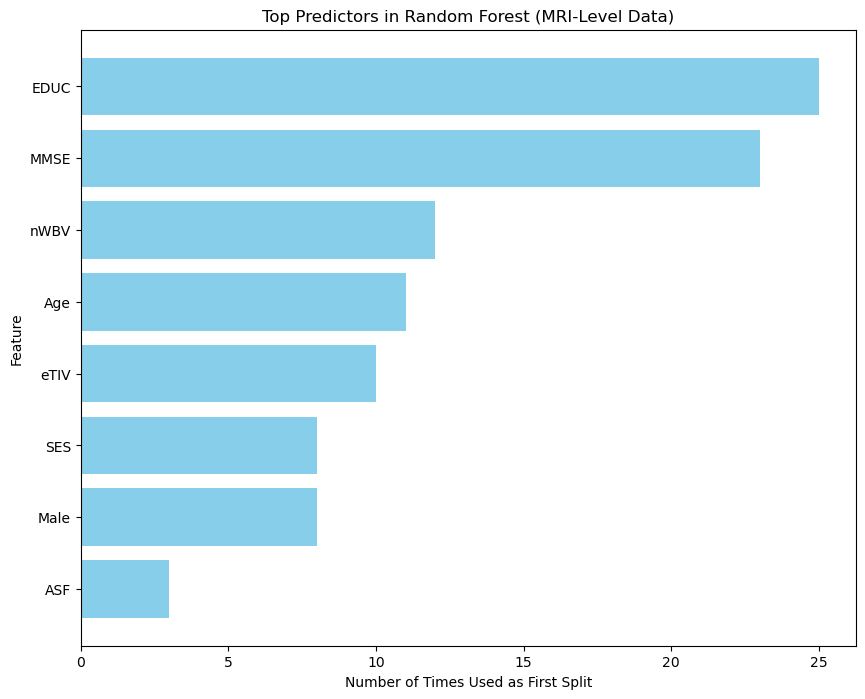

In [92]:
top_predictors_rf_mri['Count'] = pd.to_numeric(top_predictors_rf_mri['Count'])

top_predictors_rf_mri = top_predictors_rf_mri.sort_values(by='Count', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_predictors_rf_mri['Feature'], top_predictors_rf_mri['Count'], color='skyblue')
plt.xlabel('Number of Times Used as First Split')
plt.ylabel('Feature')
plt.title('Top Predictors in Random Forest (MRI-Level Data)')
plt.show()

This plot indicates that EDUC is used as the predictor for the first split slightly more often than MMSE, which was the most-used predictor in the subject-level models. This is the first model that we have seen to significantly prioritize EDUC.

### Fourth Model: XGBoost <a name="mri_xg"></a>

We will now implement a XGBoost model to classify the presence of dementia.

In [93]:
xgb_model = xgb.XGBClassifier()
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12], 'n_estimators':[100, 150, 200, 250, 300, 400], 'learning_rate': [0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001]}
clf = GridSearchCV(xgb_model, parameters, cv=5, n_jobs=-1, scoring = 'f1')
clf.fit(X_train_scaled_mri, y_train_mri)

print(clf.best_params_)

xgb_model_mri = xgb.XGBClassifier(
    max_depth=clf.best_params_['max_depth'],
    n_estimators=clf.best_params_['n_estimators'],
    learning_rate=clf.best_params_['learning_rate'], random_state=42)

xgb_model_mri.fit(X_train_scaled_mri, y_train_mri)

xgb_train_score = xgb_model_mri.score(X_train_scaled_mri, y_train_mri)
xgb_test_score = xgb_model_mri.score(X_test_scaled_mri, y_test_mri)
y_train_pred = xgb_model_mri.predict(X_train_scaled_mri)
y_test_pred = xgb_model_mri.predict(X_test_scaled_mri)
f1_train_score = f1_score(y_train_mri, y_train_pred)
f1_test_score = f1_score(y_test_mri, y_test_pred)

{'learning_rate': 0.25, 'max_depth': 1, 'n_estimators': 100}


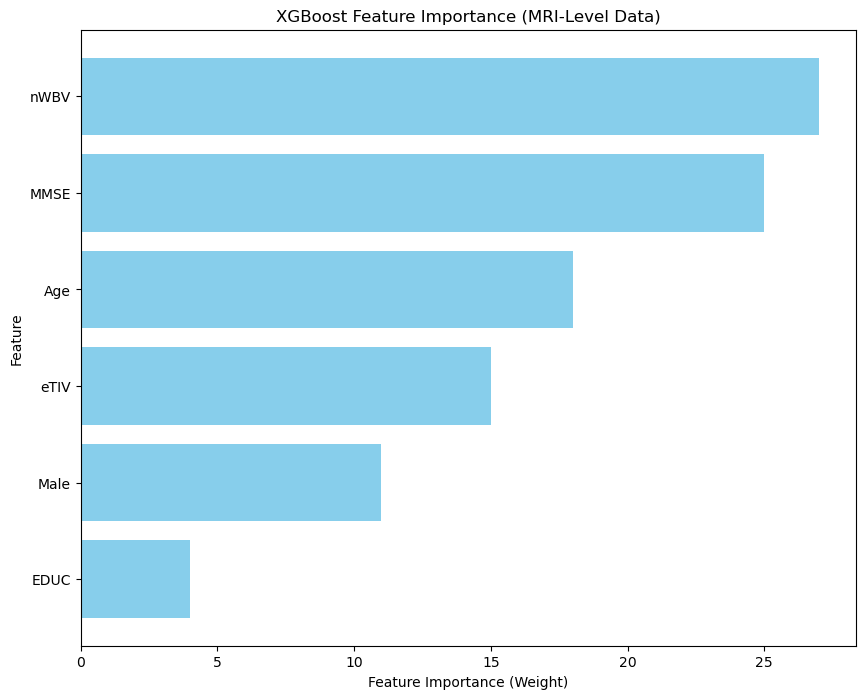

In [109]:
importance = xgb_model_mri.get_booster().get_score(importance_type='weight')
features = list(importance.keys())
importance_scores = list(importance.values())

# Sort features and importance scores in descending order
sorted_indices = sorted(range(len(importance_scores)), key=lambda k: importance_scores[k], reverse=False)
sorted_features = [features[i] for i in sorted_indices]
sorted_importance_scores = [importance_scores[i] for i in sorted_indices]

feature_labels = {'f0': 'Male', 'f1': 'Age', 'f2': 'EDUC', 'f3': 'SES', 'f4': 'MMSE', 'f5': 'eTIV', 'f6': 'nWBV', 'f7': 'ASF'}  

plt.figure(figsize=(10, 8))
plt.barh([feature_labels.get(f, f) for f in sorted_features], sorted_importance_scores, color='skyblue')
plt.xlabel('Feature Importance (Weight)')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (MRI-Level Data)')
plt.show()

The features primarily used in XGBoost for splitting were normalized whole brain volume (nWBV) and mini mental state examination (MMSE). We see a much more even distribution of splits compared to our previous models.

In [107]:
new_row_data = {
    'Model': 'Tuned XGBoost',
    'Train Accuracy Score': xgb_train_score,  
    'Test Accuracy Score': xgb_test_score,   
    'F1 Train Score': f1_train_score,       
    'F1 Test Score': f1_test_score         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS_mri = pd.concat([MODELS_mri, new_row_df], ignore_index=True)
display(MODELS_mri)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Baseline Logistic Regression,0.864865,0.821429,0.816754,0.729730
1,Logistic Regression with Lasso Regularization,0.861004,0.857143,0.821782,0.809524
2,Decision Tree Best Depth = 1,0.833977,0.803571,0.745562,0.656250
3,Tuned Random Forest,0.957529,0.901786,0.945274,0.867470
4,Multi-layer Perceptron Neural Network,0.938224,0.857143,0.920000,0.800000
5,Multi-layer Perceptron Neural Network,0.938224,0.857143,0.920000,0.800000
6,Tuned XGBoost,0.884170,0.821429,0.836957,0.714286


For the F1 train score, the XGBoost model performs similarly to the logistic regression models. However, it performs worse than every model for the F1 test score except for the decision tree.

### Fifth Model: Multi-Layer Perceptron Neural Network <a name="mri_nn"></a>

In [102]:
param_grid = {
    'hidden_layer_sizes': [
    (9,3),
    (8, 4),
    (10,5),
    (30, 10),
    (40,10)
],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
}

# Create an MLPClassifier instance
neural_network = MLPClassifier(random_state=42, max_iter=10000)


# Perform GridSearchCV
grid_search = GridSearchCV(neural_network, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled_mri, y_train_mri)

# Get the best parameters and best score
best_hidden_layer_sizes = grid_search.best_params_['hidden_layer_sizes']
best_activation = grid_search.best_params_['activation']
best_alpha = grid_search.best_params_['alpha']
best_learning_rate = grid_search.best_params_['learning_rate']


# Fit a neural network based on the best parameters
best_neural_network_mri = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, activation = best_activation,
                                    alpha = best_alpha, learning_rate = best_learning_rate, random_state=42, max_iter=10000)
best_neural_network_mri.fit(X_train_scaled_mri, y_train_mri)

train_accuracy = best_neural_network_mri.score(X_train_scaled_mri, y_train_mri)
test_accuracy = best_neural_network_mri.score(X_test_scaled_mri, y_test_mri)

y_pred_train = best_neural_network_mri.predict(X_train_scaled_mri)
y_pred_test = best_neural_network_mri.predict(X_test_scaled_mri)

f1_train = f1_score(y_train_mri, y_pred_train)
f1_test = f1_score(y_test_mri, y_pred_test)

In [103]:
grid_search.best_params_

{'activation': 'relu',
 'alpha': 0.01,
 'hidden_layer_sizes': (8, 4),
 'learning_rate': 'constant'}

We trained a MLP with these parameters.

In [106]:
new_row_data = {
    'Model': 'Multi-layer Perceptron Neural Network',
    'Train Accuracy Score': train_accuracy,  
    'Test Accuracy Score': test_accuracy,   
    'F1 Train Score': f1_train,       
    'F1 Test Score': f1_test         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS_mri = pd.concat([MODELS_mri, new_row_df], ignore_index=True)
display(MODELS_mri)

,Model,Train Accuracy Score,Test Accuracy Score,F1 Train Score,F1 Test Score
0,Baseline Logistic Regression,0.864865,0.821429,0.816754,0.729730
1,Logistic Regression with Lasso Regularization,0.861004,0.857143,0.821782,0.809524
2,Decision Tree Best Depth = 1,0.833977,0.803571,0.745562,0.656250
3,Tuned Random Forest,0.957529,0.901786,0.945274,0.867470
4,Multi-layer Perceptron Neural Network,0.938224,0.857143,0.920000,0.800000
5,Multi-layer Perceptron Neural Network,0.938224,0.857143,0.920000,0.800000


On the training data, the multi-layer perceptron performed better than every model except for the random forest. On the test data, the multi-layer perceptron performed worse than the random forest and just barely worse than the regularized logistic regression model.

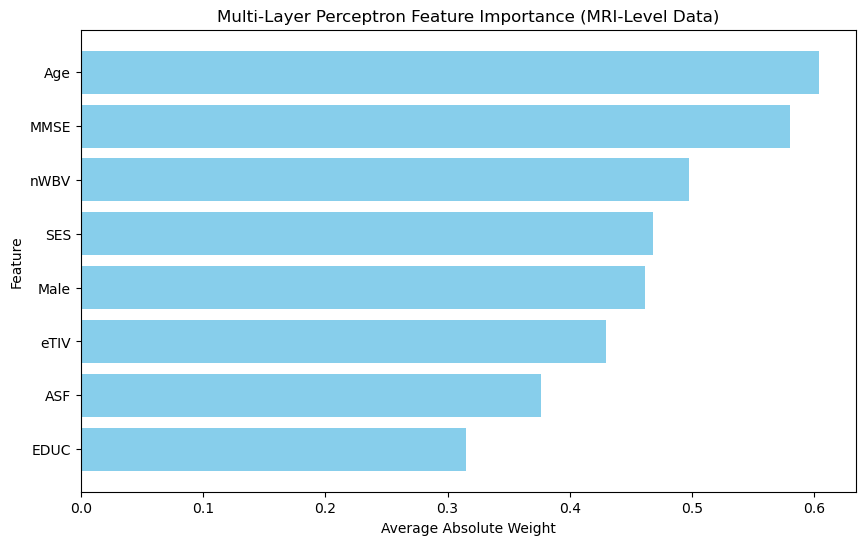

In [105]:
# Calculate the mean of the coefficient weights
weights = best_neural_network_mri.coefs_[0]
mean_abs_weights = np.abs(weights).mean(axis=1)

# Sort feature importance by mean absolute weight in ascending order
sorted_indices = np.argsort(mean_abs_weights)
sorted_baseline_predictors = [baseline_predictors[i] for i in sorted_indices]
sorted_weights = mean_abs_weights[sorted_indices]

# Plotting with sorted feature names as y-axis labels
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_weights)), sorted_weights, color = 'skyblue')
plt.xlabel('Average Absolute Weight')
plt.ylabel('Feature')
plt.yticks(range(len(sorted_weights)), sorted_baseline_predictors)  
plt.title('Multi-Layer Perceptron Feature Importance (MRI-Level Data)')
plt.show()

## Analyzing the Performance of the Different Models <a name="performance"></a>

Now we will analyze how the different models performed on the data.

### Subject-level data <a name="sub_performance"></a>

##### Names of the models

- Baseline logistic regression: baseline_model_subject
- Tuned logistic regression: logistic_lasso_sub
- Tuned decision tree: dt_best_depth_sub
- Tuned random forest: rf_best_hyperparameters_sub
- Tuned XGBoost: xgb_model_sub
- Neural Network: best_neural_network_sub

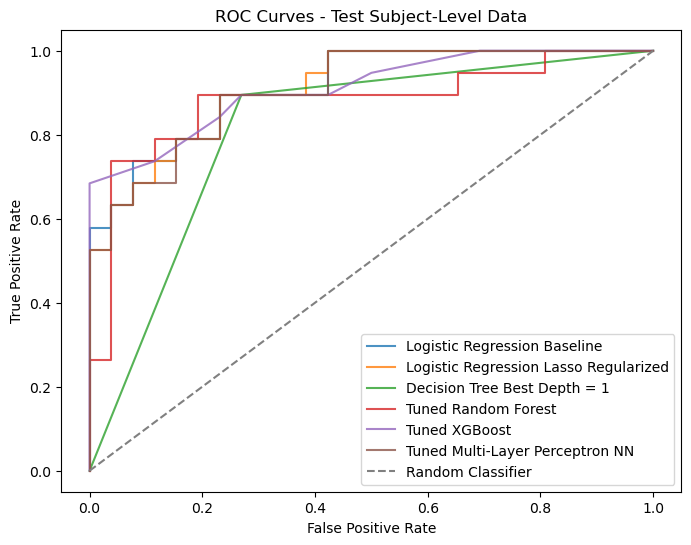

In [85]:
model_names = list(MODELS.Model)

# your code here
models = [baseline_model_subject, logistic_lasso_sub, dt_best_depth_sub, rf_best_hyperparameters_sub, xgb_model_sub, best_neural_network_sub]
model_labels = [label for label in model_names]

plt.figure(figsize=(8, 6))

for model, label in zip(models, model_labels):
    y_proba_pred = model.predict_proba(X_test_scaled_sub)[::, 1]
    fpr, tpr, thresholds = roc_curve(y_test_sub, y_proba_pred)
    plt.plot(fpr, tpr, label=f'{label}', alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Set labels and title
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curves - Test Subject-Level Data');
plt.legend();

In [86]:
auc_list = []

for model, label in zip(models, model_labels):
    y_proba_pred = model.predict_proba(X_test_scaled_sub)[::, 1]
    auc_list.append(roc_auc_score(y_test_sub, y_proba_pred))

data = {'Model': model_labels, 'AUC Score': auc_list}
df = pd.DataFrame(data)
df

,Model,AUC Score
0,Logistic Regression Baseline,0.912955
1,Logistic Regression Lasso Regularized,0.910931
2,Decision Tree Best Depth = 1,0.812753
3,Tuned Random Forest,0.878543
4,Tuned XGBoost,0.909919
5,Tuned Multi-Layer Perceptron NN,0.906883


In [87]:
# Run the models on different train test splits of the data to get an average performance of the models
# Doing all of them except for XGBoost with SMOTE

models = [baseline_model_subject, logistic_lasso_sub, dt_best_depth_sub, rf_best_hyperparameters_sub, xgb_model_sub, best_neural_network_sub]
#models = [baseline_model_subject]
num_iterations = 100

scaler = StandardScaler()


f1_train_scores = {model.__class__.__name__: [] for model in models}
f1_test_scores = {model.__class__.__name__: [] for model in models}
train_accuracy_scores = {model.__class__.__name__: [] for model in models}
test_accuracy_scores = {model.__class__.__name__: [] for model in models}

f1_train_scores.update({'XGBoostSmote': []})
f1_test_scores.update({'XGBoostSmote': []})
train_accuracy_scores.update({'XGBoostSmote': []})
test_accuracy_scores.update({'XGBoostSmote': []})


for model in models:
    for i in range(num_iterations):
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(subject_level_df[baseline_predictors], subject_level_df['demented'], 
                                                                    test_size=0.3, random_state=i, stratify=subject_level_df['demented'])

        X_train_scaled_sub = scaler.fit_transform(X_train_sub)
        X_test_scaled_sub = scaler.transform(X_test_sub)
        
        model.fit(X_train_scaled_sub, y_train_sub)

        y_pred_train = model.predict(X_train_scaled_sub)
        y_pred_test = model.predict(X_test_scaled_sub)

        f1_train = f1_score(y_train_sub, y_pred_train)
        f1_test = f1_score(y_test_sub, y_pred_test)

        train_acc = model.score(X_train_scaled_sub, y_train_sub)
        test_acc = model.score(X_test_scaled_sub, y_test_sub)

        f1_train_scores[model.__class__.__name__].append(f1_train)
        f1_test_scores[model.__class__.__name__].append(f1_test)
        train_accuracy_scores[model.__class__.__name__].append(train_acc)
        test_accuracy_scores[model.__class__.__name__].append(test_acc)

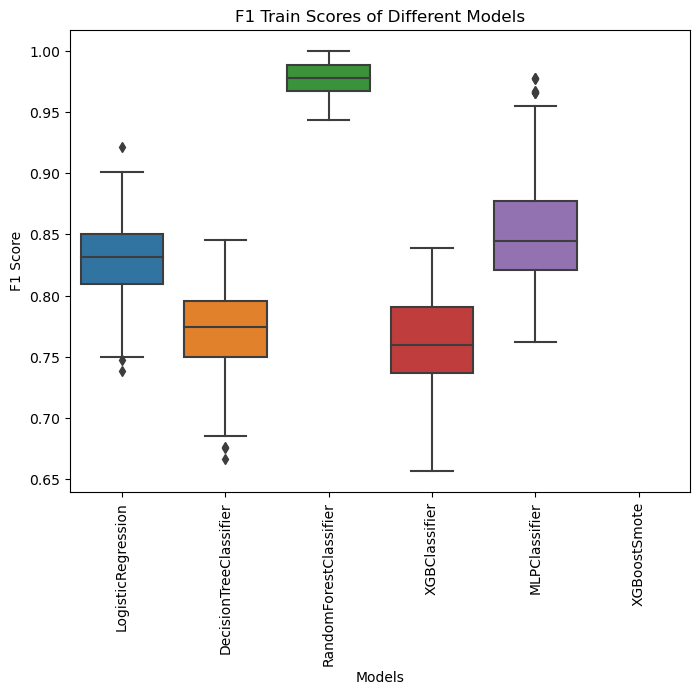

In [88]:
data = list(f1_train_scores.values())

model_names = list(f1_train_scores.keys())

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)
plt.title('F1 Train Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=90)

plt.show()

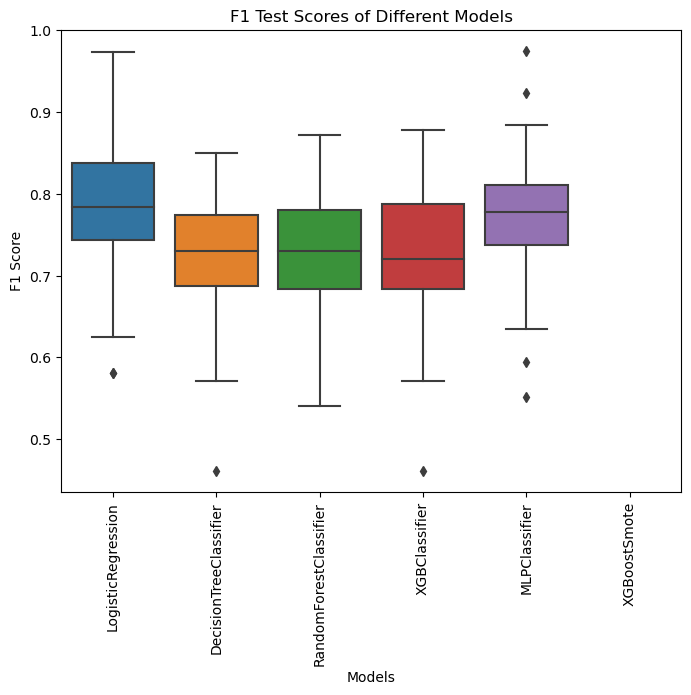

In [89]:
data = list(f1_test_scores.values())

model_names = list(f1_test_scores.keys())

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)
plt.title('F1 Test Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=90)

plt.show()


### MRI-level data <a name="mri_performance"></a>

##### Names of the models

- Baseline logistic regression: baseline_model_mri
- Tuned logistic regression: logistic_lasso_mri
- Tuned decision tree: dt_best_depth_mri
- Tuned random forest: rf_best_hyperparameters_mri
- Tuned XGBoost: xgb_model_mri
- Tuned XGBoost with SMOTE: xgb_model_mri
- Neural Network: best_neural_network_mri

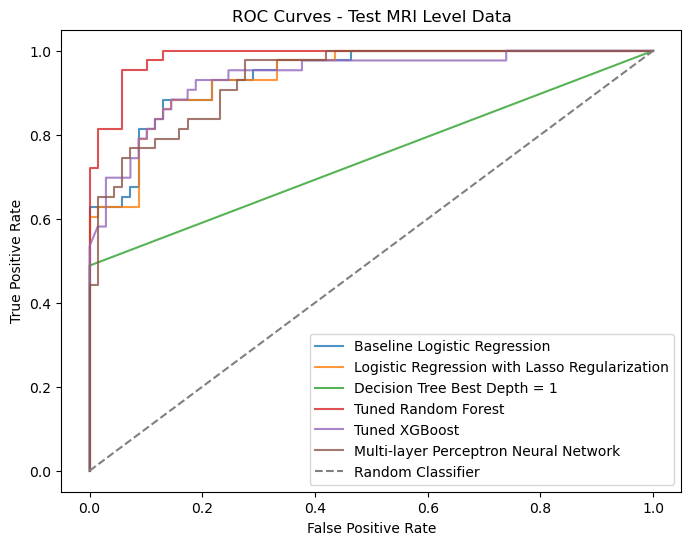

In [90]:
model_names = list(MODELS_mri.Model)

# your code here
models_mri = [baseline_model_mri, logistic_lasso_mri, dt_best_depth_mri, rf_best_hyperparameters_mri, xgb_model_mri, best_neural_network_mri]
model_labels_mri = [label for label in model_names]

plt.figure(figsize=(8, 6))

for model, label in zip(models_mri, model_labels_mri):
    y_proba_pred = model.predict_proba(X_test_scaled_mri)[::, 1]
    fpr, tpr, thresholds = roc_curve(y_test_mri, y_proba_pred)
    plt.plot(fpr, tpr, label=f'{label}', alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Set labels and title
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curves - Test MRI Level Data');
plt.legend();

In [91]:
auc_list_mri = []

for model, label in zip(models_mri, model_labels_mri):
    y_proba_pred = model.predict_proba(X_test_scaled_mri)[::, 1]
    auc_list_mri.append(roc_auc_score(y_test_mri, y_proba_pred))

data_mri = {'MRI-Level Model': model_labels_mri, 'MRI-Level AUC Score': auc_list_mri}
df_mri = pd.DataFrame(data_mri)
df_mri

,MRI-Level Model,MRI-Level AUC Score
0,Baseline Logistic Regression,0.940681
1,Logistic Regression with Lasso Regularization,0.938322
2,Decision Tree Best Depth = 1,0.744186
3,Tuned Random Forest,0.985170
4,Tuned XGBoost,0.937310
5,Multi-layer Perceptron Neural Network,0.934951


In [92]:
# Run the models on different train test splits of the data to get an average performance of the models
# Doing all of them except for XGBoost with SMOTE

models = [baseline_model_mri, logistic_lasso_mri, dt_best_depth_mri, rf_best_hyperparameters_mri, xgb_model_mri, best_neural_network_mri]
#models = [baseline_model_subject]
num_iterations = 100

scaler = StandardScaler()


f1_train_scores = {model.__class__.__name__: [] for model in models}
f1_test_scores = {model.__class__.__name__: [] for model in models}
f1_train_scores.update({'XGBoostSmote': []})
f1_test_scores.update({'XGBoostSmote': []})


for model in models:
    for i in range(num_iterations):
        X_train_mri, X_test_mri, y_train_mri, y_test_mri = train_test_split(df[baseline_predictors], df['demented'], 
                                                                    test_size=0.3, random_state=i, stratify=df['demented'])

        X_train_scaled_mri = scaler.fit_transform(X_train_mri)
        X_test_scaled_mri = scaler.transform(X_test_mri)
        
        model.fit(X_train_scaled_mri, y_train_mri)

        y_pred_train = model.predict(X_train_scaled_mri)
        y_pred_test = model.predict(X_test_scaled_mri)

        f1_train = f1_score(y_train_mri, y_pred_train)
        f1_test = f1_score(y_test_mri, y_pred_test)

        f1_train_scores[model.__class__.__name__].append(f1_train)
        f1_test_scores[model.__class__.__name__].append(f1_test)


KeyError: "None of [Index(['Male', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF'], dtype='object')] are in the [columns]"

In [ ]:
data = list(f1_train_scores.values())

model_names = list(f1_train_scores.keys())

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)
plt.title('F1 Train Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=90)

plt.show()

In [ ]:
data = list(f1_test_scores.values())

model_names = list(f1_test_scores.keys())

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data)
plt.title('F1 Test Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.xticks(ticks=range(len(model_names)), labels=model_names, rotation=90)
plt.show()


## Deep Dive into Random Forest 

###  Random Forests with Oversampling - MRI Level

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled_mri, y_train_mri)

rf_tuned_resampled = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                  param_grid={'min_samples_split': [2,3,4,5],
                              'max_features': [2,3,4,5]},         
                  cv=5, scoring='f1')

rf_tuned_resampled.fit(X_train_resampled, y_train_resampled)
best_max_features = rf_tuned_resampled.best_params_['max_features']
best_min_samples = rf_tuned_resampled.best_params_['min_samples_split']

rf_best_hyperparameters_mri = RandomForestClassifier(random_state = 42, max_features=best_max_features, min_samples_split=best_min_samples, class_weight='balanced')

rf_best_hyperparameters_mri.fit(X_train_resampled,y_train_resampled)
rf_resampled_train_score = rf_best_hyperparameters_mri.score(X_train_scaled_mri, y_train_mri) 
rf_resampled_test_score = rf_best_hyperparameters_mri.score(X_test_scaled_mri, y_test_mri)

rf_train_pred = rf_best_hyperparameters_mri.predict(X_train_scaled_mri)
rf_test_pred = rf_best_hyperparameters_mri.predict(X_test_scaled_mri)

f1_rf_resampled_train_score = f1_score(y_train_mri, rf_train_pred)
f1_rf_resampled_test_score = f1_score(y_test_mri, rf_test_pred)

new_row_data = {
    'Model': 'Tuned Random Forest with Oversampling',
    'Train Accuracy Score': rf_resampled_train_score,  
    'Test Accuracy Score': rf_resampled_test_score,   
    'F1 Train Score': f1_rf_resampled_train_score,       
    'F1 Test Score': f1_rf_resampled_test_score         
}

new_row_df = pd.DataFrame([new_row_data])
MODELS_mri = pd.concat([MODELS_mri, new_row_df], ignore_index=True)
display(MODELS_mri)

###  Random Forests with Oversampling - Subject Level

In [ ]:
from imblearn.over_sampling import RandomOverSampler


oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_scaled_sub, y_train_sub)

rf_tuned_resampled = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                  param_grid={'min_samples_split': [2,3,4,5],
                              'max_features': [2,3,4,5]},         
                  cv=5, scoring='f1')

rf_tuned_resampled.fit(X_train_resampled, y_train_resampled)
best_max_features = rf_tuned_resampled.best_params_['max_features']
best_min_samples = rf_tuned_resampled.best_params_['min_samples_split']

rf_best_hyperparameters_sub = RandomForestClassifier(random_state = 42, max_features=best_max_features, min_samples_split=best_min_samples, class_weight='balanced')
rf_best_hyperparameters_sub.fit(X_train_resampled,y_train_resampled)
rf_resampled_train_score = rf_best_hyperparameters_sub.score(X_train_scaled_sub, y_train_sub) 
rf_resampled_test_score = rf_best_hyperparameters_sub.score(X_test_scaled_sub, y_test_sub)
rf_resampled_train_pred = rf_best_hyperparameters_sub.predict(X_train_scaled_sub)
rf_resampled_test_pred = rf_best_hyperparameters_sub.predict(X_test_scaled_sub)
f1_rf_resampled_train_score = f1_score(y_train_sub, rf_resampled_train_pred)
f1_rf_resampled_test_score = f1_score(y_test_sub, rf_resampled_test_pred)

new_row_data = {
    'Model': 'Tuned Random Forest with Oversampling',
    'Train Accuracy Score': rf_resampled_train_score,  
    'Test Accuracy Score': rf_resampled_test_score,   
    'F1 Train Score': f1_rf_resampled_train_score,       
    'F1 Test Score': f1_rf_resampled_test_score         
}
new_row_df = pd.DataFrame([new_row_data])
MODELS = pd.concat([MODELS, new_row_df], ignore_index=True)
display(MODELS)

## Results <a name="results"></a>

## Future Work/Scope of Improvement <a name="future"></a>